In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import statsmodels.api as sm
from datetime import datetime
from scipy.stats.mstats import winsorize
from scipy import stats
import warnings

In [2]:
#ignore warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float.format','{:.2f}'.format)

In [3]:
#importing data files
data =pd.read_excel(r"C:\Users\LENOVO\OneDrive\Desktop\WDI DATA\data for python analysis\trade elasticity analysis.xlsx")
metadata=pd.read_excel(r"C:\Users\LENOVO\OneDrive\Desktop\WDI DATA\data for python analysis\metadata.xlsx", sheet_name ='Country - Metadata')
df=pd.merge(metadata,data)
country_data=df[df['Region'].notna()].copy()
agg_data=df[df['Region'].isna()].copy()
df_cleaned = country_data.replace('..',np.nan)
df_cleaned.keys()

Index(['Region', 'Country name', 'Income group', 'Year',
       'Exports of goods and services (% of GDP)',
       'Exports of goods and services', 'Service exports (BoP, current US$)',
       'Trade in services (% of GDP)',
       'Net trade in goods and services (BoP, current US$)',
       'High-technology exports (% of manufactured exports)',
       'Trade (% of GDP)', 'ICT service exports (% of service exports, BoP)',
       'GDP growth (annual %)', 'Official exchange rate (LCU per US$)',
       'Tariff rate', 'Inflation consumer prices',
       'Goods exports (BoP, current US$)', 'GDP (current US$) ',
       'GDP per capita'],
      dtype='object')

In [4]:
#examining data
df = df_cleaned.copy()
print(f'Data set shape: {df.shape}')
print(f'\nBasic info: {df.info()}')
print('\nMissing values per column:')
print(df.isnull().sum().sort_values(ascending = False))

Data set shape: (7455, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 7455 entries, 0 to 8959
Data columns (total 19 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Region                                               7455 non-null   object 
 1   Country name                                         7455 non-null   object 
 2   Income group                                         7455 non-null   object 
 3   Year                                                 7455 non-null   int64  
 4   Exports of goods and services (% of GDP)             5766 non-null   float64
 5   Exports of goods and services                        4950 non-null   float64
 6   Service exports (BoP, current US$)                   5590 non-null   float64
 7   Trade in services (% of GDP)                         5544 non-null   float64
 8   Net trade in goods and services (BoP, current 

In [5]:
#column standardization 
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('%','pct')
col_mapping = {'region':'region',
               'country_name':'country',
               'income_group':'income_group',
               'year':'year',
               'exports_of_goods_and_services_pct_of_gdp':'exports_gdp_pct',
       'exports_of_goods_and_services':'exports_growth', 
               'service_exports_bop,_current_us$':'service_exports_usd',
       'trade_in_services_pct_of_gdp':'service_exports_gdp_pct',
       'net_trade_in_goods_and_services_bop,_current_us$':'net_trade_usd',
       'high-technology_exports_pct_of_manufactured_exports':'hitech_exports_pct',
       'trade_pct_of_gdp':'trade_openness_pct',
        'ict_service_exports_pct_of_service_exports,_bop':'ict_service_exports_pct',
       'gdp_growth_annual_pct':'gdp_growth', 
               'official_exchange_rate_lcu_per_us$':'exch_rate',
       'tariff_rate':'tariff_rate',
               'inflation_consumer_prices':'inflation',
       'goods_exports_bop,_current_us$':'goods_exports_usd',
               'gdp_current_us$':'gdp_usd', 'gdp_per_capita':'gdp_pc_usd'}
df = df.rename(columns = col_mapping)
len(df.keys()[4:])

15

In [6]:
#missing data diagnosis
print(f'total country-year obs {len(df)}')
total_cells = np.prod(df.shape)
missing_cells = df.isnull().sum().sum()
print(f'overall missigness: {missing_cells/total_cells:.2%}')
missing_by_col = df.isnull().mean().sort_values(ascending = False) *100
print(missing_by_col)
missing_by_country = df.groupby('country').apply(lambda x:x.isnull().mean().mean()*100)
print(f'\nTop 10 countries with most missing data\n:{missing_by_country.sort_values(ascending =False).head(5)}')
missing_by_year = df.groupby('year').apply(lambda x:x.isnull().mean().mean()*100)
print(f'\nYears with the most missing_data\n:{missing_by_year.sort_values(ascending =False).head(5)} ')
orig_df = df.copy()

total country-year obs 7455
overall missigness: 20.47%
hitech_exports_pct        66.79
tariff_rate               50.48
ict_service_exports_pct   37.26
exports_growth            33.60
service_exports_gdp_pct   25.63
goods_exports_usd         25.02
service_exports_usd       25.02
net_trade_usd             25.02
exports_gdp_pct           22.66
trade_openness_pct        22.66
inflation                 21.80
gdp_pc_usd                10.07
gdp_growth                 9.30
exch_rate                  7.16
gdp_usd                    6.47
country                    0.00
year                       0.00
income_group               0.00
region                     0.00
dtype: float64

Top 10 countries with most missing data
:country
Korea, Dem. People's Rep.   74.29
British Virgin Islands      74.29
Gibraltar                   69.17
St. Martin (French part)    67.37
Liechtenstein               65.86
dtype: float64

Years with the most missing_data
:year
2024   63.58
1990   35.56
1991   34.32
1992   3

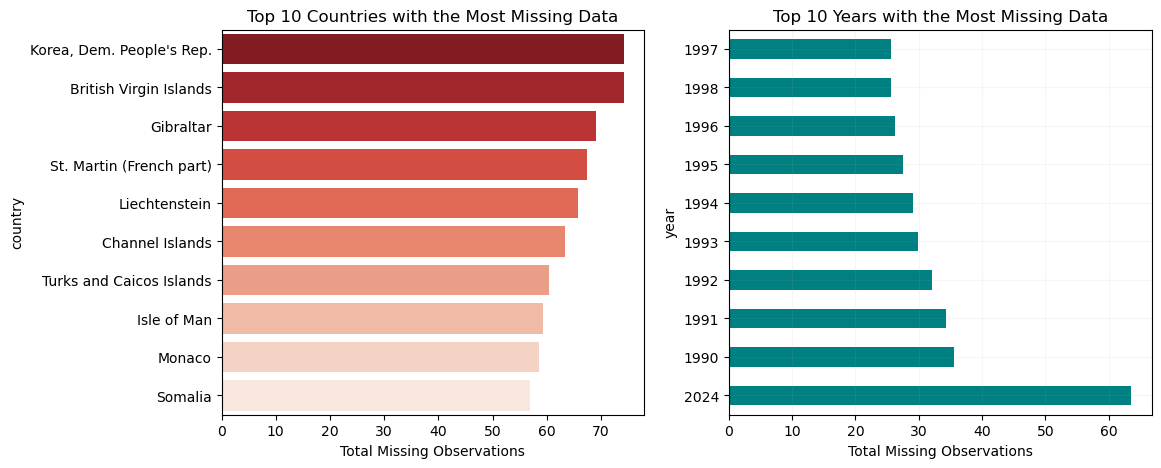

In [7]:
#visualising data missingness
top_country =missing_by_country.sort_values(ascending =False).head(10)
top_year = missing_by_year.sort_values(ascending =False).head(10)
fig,(ax1,ax2) = plt.subplots(1,2, figsize =(12,5))
sns.barplot(x=top_country.values, y=top_country.index, ax = ax1, palette = 'Reds_r')
ax1.set_title('Top 10 Countries with the Most Missing Data')
ax1.set_xlabel('Total Missing Observations')

top_year.plot(kind = 'barh', color = 'Teal')
ax2.set_title('Top 10 Years with the Most Missing Data')
ax2.set_xlabel('Total Missing Observations')
plt.grid(alpha = 0.1)
plt.savefig('missingness', dpi = 300, bbox_inches ='tight', facecolor = 'white')

In [8]:
#dropped vars with missingness above 50%
vars_to_keep = df[['region', 'country', 'income_group', 'year', 'exports_gdp_pct',
       'exports_growth', 'service_exports_usd', 'service_exports_gdp_pct',
       'net_trade_usd', 'trade_openness_pct',
       'ict_service_exports_pct', 'gdp_growth', 'exch_rate',
       'inflation', 'goods_exports_usd', 'gdp_usd', 'gdp_pc_usd']]
#backward and foward fill for nans
vars_to_keep = vars_to_keep.sort_values(['country', 'year'])
numeric_cols = vars_to_keep.columns[4:]
for col in numeric_cols:
    vars_to_keep[col] =vars_to_keep.groupby('country')[col].ffill().bfill()

#data expolartion (descrptive statistics before transformation)
df = vars_to_keep.copy()
numeric_vars = df.select_dtypes(include = [np.number]).columns.tolist()
non_econ_var = ['year']
analysis_vars = [var for var in numeric_vars if var not in non_econ_var]
print(f'Analysizing {len(analysis_vars)} economic variables')
stats_df = pd.DataFrame(index = analysis_vars, columns =['mean','std',
                       'skew', 'kurtosis'])
for var in analysis_vars:
    stats_df.loc[var, 'mean'] = df[var].mean()
    stats_df.loc[var, 'std'] = df[var].std()
    stats_df.loc[var, 'skew'] = df[var].skew()
    stats_df.loc[var, 'kurtosis'] = df[var].kurtosis()
stats_df.sort_values(['skew', 'kurtosis'], ascending = False)

Analysizing 13 economic variables


,mean,std,skew,kurtosis
inflation,50.75,420.40,28.82,1404.44
exch_rate,10822429.05,269533375.21,24.87,616.67
exports_growth,6.17,33.29,14.19,291.36
gdp_usd,242491551518.43,1212670103289.11,11.62,166.12
service_exports_usd,16918986728.06,58580581540.50,8.05,89.95
goods_exports_usd,57044779846.58,185048933287.83,7.92,90.11
gdp_pc_usd,13185.07,22189.34,3.76,21.41
ict_service_exports_pct,6.85,8.57,3.53,21.35
service_exports_gdp_pct,27.21,28.07,3.28,18.13
trade_openness_pct,86.87,58.11,2.84,14.87


In [9]:
#interpretaion of skewness and kurtosis
print('Skewness analysis: (skew) > 1 indicates asymmetry')
high_skew = stats_df[abs(stats_df['skew'] >1)]
print(high_skew[['skew', 'kurtosis']].sort_values('skew', key = abs, ascending = False))
print('Kurtosis analysis: (kurtosis) > 3 indicates heavy tails')
high_kurt = stats_df[abs(stats_df['skew'] >1)]
print(high_skew[['kurtosis','skew']].sort_values('kurtosis', key = abs, ascending = False))


Skewness analysis: (skew) > 1 indicates asymmetry
                         skew kurtosis
inflation               28.82  1404.44
exch_rate               24.87   616.67
exports_growth          14.19   291.36
gdp_usd                 11.62   166.12
service_exports_usd      8.05    89.95
goods_exports_usd        7.92    90.11
gdp_pc_usd               3.76    21.41
ict_service_exports_pct  3.53    21.35
service_exports_gdp_pct  3.28    18.13
trade_openness_pct       2.84    14.87
exports_gdp_pct          2.67    12.66
gdp_growth               2.22    57.99
Kurtosis analysis: (kurtosis) > 3 indicates heavy tails
                        kurtosis  skew
inflation                1404.44 28.82
exch_rate                 616.67 24.87
exports_growth            291.36 14.19
gdp_usd                   166.12 11.62
goods_exports_usd          90.11  7.92
service_exports_usd        89.95  8.05
gdp_growth                 57.99  2.22
gdp_pc_usd                 21.41  3.76
ict_service_exports_pct    21.35  3.

In [10]:
#variable transformation(logs and log returns)
df = vars_to_keep.copy()

numeric_vars = df.select_dtypes(include = [np.number]).columns.tolist()
non_econ_var = ['year']
analysis_vars = [var for var in numeric_vars if var not in non_econ_var]

level_vars = [col for col in df.columns if 'usd' in col.lower() and 'growth' not in col]
pct_vars =[col for col in df.columns if 'pct' in col.lower()]
growth_vars = [col for col in df.columns if 'growth' in col.lower()]
indice_vars = ['inflation', 'exch_rate']

for var in level_vars:
    if var in df.columns:
        df = df[df[var] >0]
log_vars = []
for var in level_vars:
    if var in df.columns:
        log_var =f'log_{var}'
        df[log_var] =np.log(df[var])
        log_vars.append(log_var)
for var in log_vars:
    base_var =var.replace('log_','')
    growth_var =f'{base_var}_log_return'
    df[growth_var] =df.groupby('country')[var].diff()
log_return_vars=['service_exports_usd_log_return',
       'net_trade_usd_log_return', 
        'goods_exports_usd_log_return',
       'gdp_usd_log_return',
        'gdp_pc_usd_log_return']
for col in log_return_vars:
    if col in df.columns:
        df[col]= df[col].clip(lower = -2, upper = 2)


In [11]:
#clipping extreme values
df['trade_openness_pct']=df['trade_openness_pct'].clip(lower =0, upper = 250)
df['exports_gdp_pct']=df['exports_gdp_pct'].clip(lower = 0, upper =150)
df['service_exports_gdp_pct'] =df['service_exports_gdp_pct'].clip(lower =0, upper =100)
df['inflation'] =df['inflation'].clip(lower =-10, upper =100)
df['exports_growth'] =df['exports_growth'].clip(lower = -50, upper 
                                                =50)
df['log_exch_rate'] =np.log(df['exch_rate'])
transformed_df = df.copy()

In [12]:
#descriptive statistics after data transformation
stats_df = pd.DataFrame(index = analysis_vars, columns =['mean','std',
                       'skew', 'kurtosis'])
dist_vars = ['service_exports_usd_log_return',
       'net_trade_usd_log_return', 
        'goods_exports_usd_log_return',
       'gdp_usd_log_return',
        'gdp_pc_usd_log_return', 
        'exports_gdp_pct',
       'exports_growth',
        'service_exports_gdp_pct', 
        'trade_openness_pct', 
        'ict_service_exports_pct', 'gdp_growth',
       'log_exch_rate', 'inflation'] 
for var in dist_vars:
    if var in df.columns:
        stats_df.loc[var, 'mean'] = df[var].mean()
        stats_df.loc[var, 'std'] = df[var].std()
        stats_df.loc[var, 'skew'] = df[var].skew()
        stats_df.loc[var, 'kurtosis'] = df[var].kurtosis()

stats_df['skew_severity'] =stats_df['skew'].abs().map(lambda x: 'Low' if x <1 else'Moderate' if x<=2 else 'High')
stats_df['kurtosis_severity'] =stats_df['kurtosis'].abs().map(lambda x: 'Normal' if x <3 else'Heavy tails' if x<=10 else 'Extreme')

stats_df = stats_df.sort_values(by = 'skew', ascending = False)
stats_df.dropna()

,mean,std,skew,kurtosis,skew_severity,kurtosis_severity
ict_service_exports_pct,6.11,8.47,3.27,12.88,High,Extreme
inflation,10.37,21.35,3.18,9.42,High,Heavy tails
gdp_usd_log_return,0.10,0.27,3.03,16.21,High,Extreme
goods_exports_usd_log_return,0.06,0.25,2.29,20.75,High,Extreme
gdp_growth,2.95,6.39,1.76,34.29,Moderate,Extreme
exports_gdp_pct,53.30,32.22,1.30,1.75,Moderate,Normal
service_exports_gdp_pct,30.90,29.00,1.28,0.24,Moderate,Normal
service_exports_usd_log_return,0.07,0.27,1.24,17.07,Moderate,Extreme
trade_openness_pct,98.81,55.03,1.19,1.03,Moderate,Normal
log_exch_rate,2.18,2.97,0.80,1.81,Low,Normal


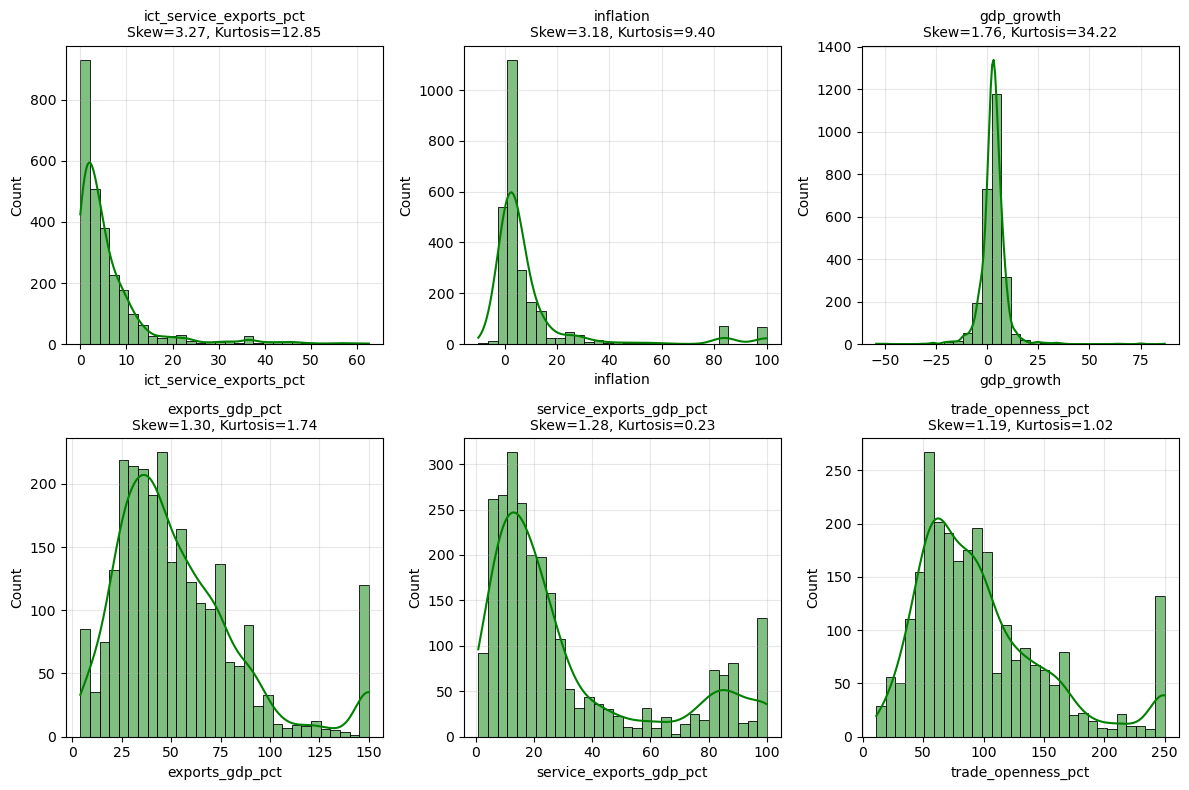

In [13]:
# Plot distributions for problem indicators with high skewness 
from scipy.stats import skew, kurtosis
plot_cols =[ 'ict_service_exports_pct','inflation','gdp_growth',
    'exports_gdp_pct','service_exports_gdp_pct','trade_openness_pct']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for ax, var in zip(axes.flatten(), plot_cols):
    sns.histplot(transformed_df[var].dropna(), kde=True, ax=ax, bins =30, color = 'green')
    ax.set_title(f"{var}\nSkew={skew(transformed_df[var].dropna()):.2f}, Kurtosis={kurtosis(df[var].dropna()):.2f}", fontsize = 10)
    ax.grid(alpha =0.3)
   
plt.tight_layout()
plt.show()

In [14]:
#correcting skewness
#applying IHS -inverse hyperbolic sine transformation 
skew_correct_df = transformed_df[['ict_service_exports_pct','inflation','gdp_growth',
    'exports_gdp_pct','service_exports_gdp_pct','trade_openness_pct']]
skew_correct_df['ict_service_exports_pct'] =np.arcsinh(skew_correct_df['ict_service_exports_pct'])
skew_correct_df['inflation'] =np.arcsinh(skew_correct_df['inflation'])
skew_correct_df['gdp_growth'] =np.arcsinh(skew_correct_df['gdp_growth'])
skew_correct_df['exports_gdp_pct'] =np.arcsinh(skew_correct_df['exports_gdp_pct'])

skwed_vars = skew_correct_df.columns
dist_stats2 = pd.DataFrame({
    'Variable': skwed_vars,
    'Skewness': [skew(skew_correct_df[var].dropna()) for var in skwed_vars],
    'Kurtosis': [kurtosis(skew_correct_df[var].dropna()) for var in skwed_vars],
    'Outliers?': ['Yes' if (skew(skew_correct_df[var].dropna()) > 2) | (kurtosis(skew_correct_df[var].dropna()) > 5) else 'No' for var in skwed_vars]
}).set_index('Variable')


print('IHS has dealt with the high kurtosis and skewness')
dist_stats2

IHS has dealt with the high kurtosis and skewness


,Skewness,Kurtosis,Outliers?
Variable,,,
ict_service_exports_pct,0.21,-0.48,No
inflation,0.21,0.33,No
gdp_growth,-1.15,0.51,No
exports_gdp_pct,-0.65,1.13,No
service_exports_gdp_pct,1.28,0.23,No
trade_openness_pct,1.19,1.02,No


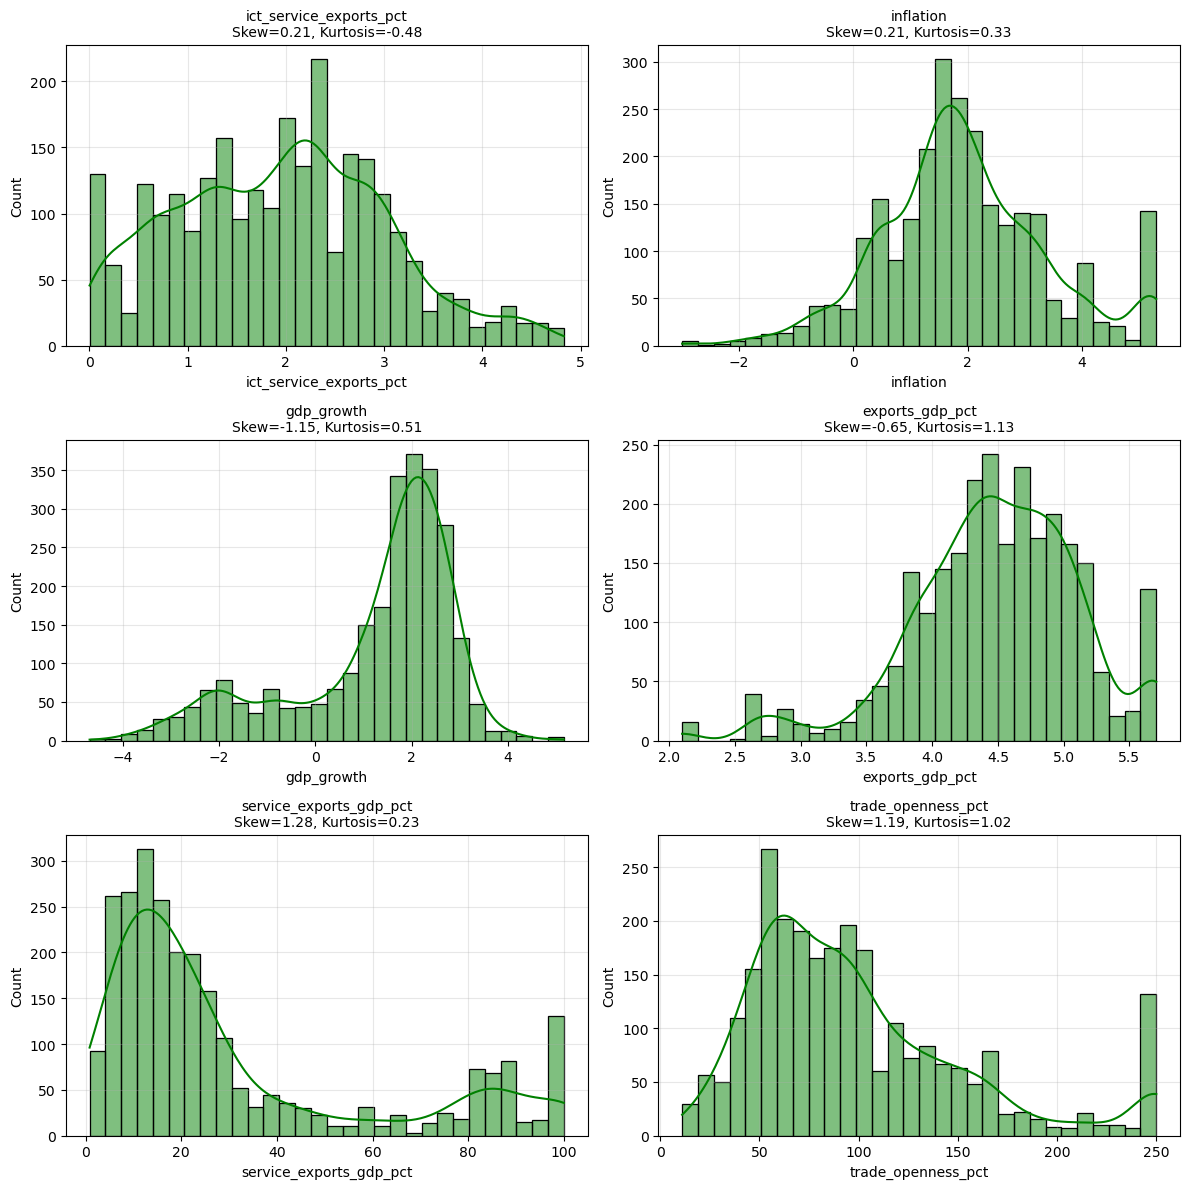

In [15]:
#second plotting distributions to show the corrected kurtosis

plot_cols =['ict_service_exports_pct','inflation','gdp_growth',
    'exports_gdp_pct','service_exports_gdp_pct','trade_openness_pct']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for ax, var in zip(axes.flatten(), plot_cols):
    sns.histplot(skew_correct_df[var].dropna(), kde=True, ax=ax, bins =30, color = 'green')
    ax.set_title(f"{var}\nSkew={skew(skew_correct_df[var].dropna()):.2f}, Kurtosis={kurtosis(skew_correct_df[var].dropna()):.2f}", fontsize = 10)
    ax.grid(alpha =0.3)
   
plt.tight_layout()
plt.show()

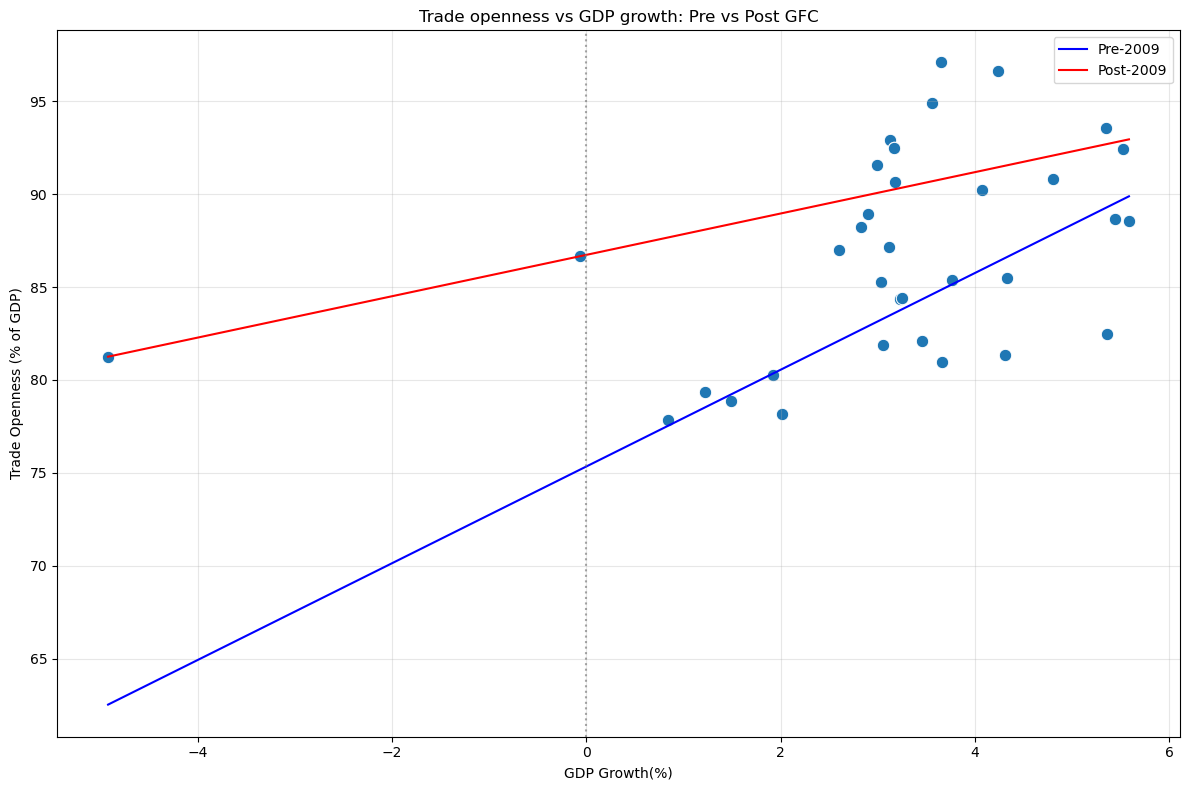

In [16]:
# trade openness pre vs post GFC
df = vars_to_keep.copy()
df = df.groupby('year')[['gdp_growth', 'trade_openness_pct']].mean()
plt.figure(figsize =(12,8))
sns.scatterplot(x= 'gdp_growth', y = 'trade_openness_pct', data = df, s = 80)
pre =df[df.index < 2009]
post = df[df.index>=2009]

coef_pre =np.polyfit(pre.gdp_growth, pre.trade_openness_pct,1)
coef_post =np.polyfit(post.gdp_growth, post.trade_openness_pct,1)

x_vals =np.linspace(df.gdp_growth.min(), df.gdp_growth.max(),100)
plt.plot(x_vals, np.polyval(coef_pre, x_vals), color = 'blue', label ='Pre-2009')
plt.plot(x_vals, np.polyval(coef_post, x_vals), color = 'red', label ='Post-2009')
plt.axvline(0, color = 'gray', ls= ':', alpha =0.7)
plt.title('Trade openness vs GDP growth: Pre vs Post GFC')
plt.xlabel('GDP Growth(%)')
plt.ylabel('Trade Openness (% of GDP)')
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.legend()
plt.savefig('pre vs post 2008 trade openness', dpi =300, bbox_inches = 'tight', facecolor = 'white')



In [17]:
#determining structural break
df['post_2008'] = (df.index >=2009).astype(int)
df['interaction'] =df.gdp_growth * df.post_2008  
X_full = sm.add_constant(df[['gdp_growth', 'post_2008','interaction']])
y = df.trade_openness_pct
model_full = sm.OLS(y,X_full).fit()
#restricted model
X_restricted = sm.add_constant(df.gdp_growth)
model_restricted = sm.OLS(y, X_restricted).fit()

#chow_test
rss_full= sum(model_full.resid **2)
rss_restricted = sum(model_restricted.resid **2)
n =len(df)
k = 4
m = 2
f_stat = ((rss_restricted -rss_full)/ (k-m))/(rss_full/(n-k))
from scipy.stats import f
p_value =1-f.cdf(f_stat, dfn =(k-m), dfd =(n-k))
print(f'chow test for structural break at 2009')
print(f'F-Statistic: {f_stat}')
print(f'P_value: {p_value:.2f}')
if p_value < 0.05:
    print('Significant structural break detected')
else:
    print('no significant break detected')

chow test for structural break at 2009
F-Statistic: 15.404940630036451
P_value: 0.00
Significant structural break detected


In [18]:
#cross ccountry dispersion trade vs GDP
#deviations in trade or growth
df = vars_to_keep.copy()
def compute_dispersion(df,var, time_col ='year'):
    grouped = df.groupby(time_col)[var]
    stats = grouped.agg(
        mean =np.mean,
        std =np.std,
        q25 = lambda x: np.percentile(x,25),
        q75 = lambda x: np.percentile(x,75),
        count ='count')
    stats['iqr'] = stats['q75'] - stats['q25']
    return stats
disp_gdp = compute_dispersion(df, 'gdp_growth')
disp_trade = compute_dispersion(df, 'trade_openness_pct')
min_countries = 50
disp_gdp = disp_gdp[disp_gdp['count']>= min_countries]
disp_trade = disp_trade[disp_trade['count']>= min_countries]
print('Top 5 years with the highest cross country gdp growth dispersion')
print(disp_gdp.nlargest(5, 'std')[['std','count']])
print('Top 5 years with the highest trade openness dispersion')
print(disp_trade.nlargest(5, 'std')[['std','count']])

Top 5 years with the highest cross country gdp growth dispersion
       std  count
year             
1997 13.31    213
1992 11.33    213
1991  9.08    213
1990  8.78    213
2020  8.57    213
Top 5 years with the highest trade openness dispersion
       std  count
year             
2008 77.87    213
2011 69.66    213
2006 64.73    213
2010 64.43    213
2007 64.32    213


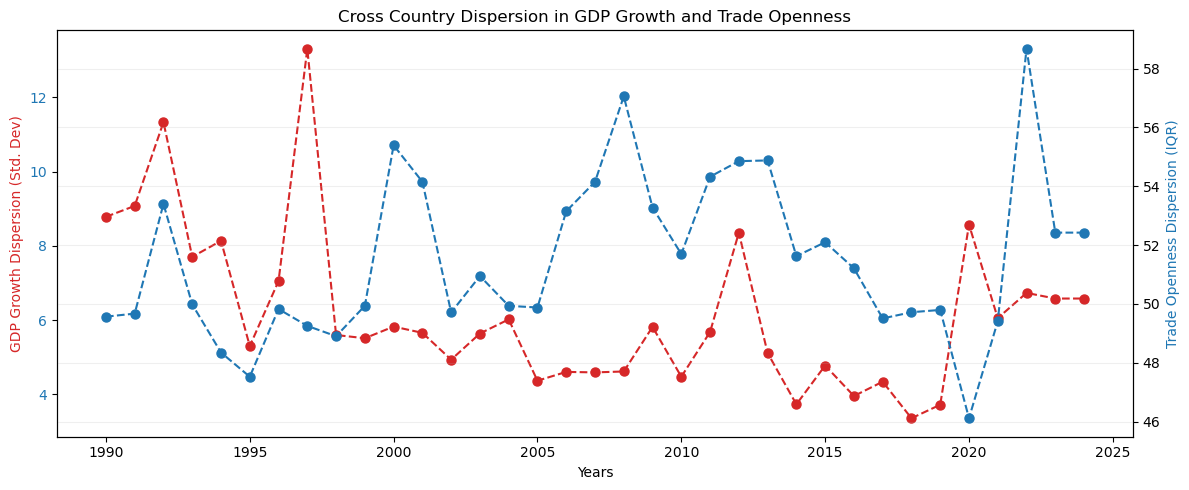

In [19]:
#visualisation cross country dispersion 
fig,ax1 = plt.subplots(figsize =(12,5))
color = 'tab:red'
ax1.plot(disp_gdp.index,disp_gdp['std'], color = color, marker = 'o', markersize = 6.5, ls= '--', label = 'Gdp growth std')
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP Growth Dispersion (Std. Dev)', color = color)
ax1.tick_params(axis ='y', labelcolor =color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(disp_trade.index,disp_trade.iqr, color = color, marker = 'o', markersize = 6.5, ls= '--', label = 'trade openness IQR')
ax2.set_ylabel('Trade Openness Dispersion (IQR)', color = color)
ax1.tick_params(axis ='y', labelcolor =color)
plt.title('Cross Country Dispersion in GDP Growth and Trade Openness')
plt.tight_layout()
plt.grid(alpha = 0.2)
plt.savefig('cross_country_dispersion', dpi = 300, bbox_inches = 'tight', facecolor ='white')

In [20]:
#identifying atypical countries
data = vars_to_keep[['country','year','gdp_growth', 'trade_openness_pct']]
X = sm.add_constant(data['gdp_growth'])
y = data['trade_openness_pct']
model = sm.OLS(y,X).fit()
data['residual'] =model.resid
data['abs_residual'] =data['residual'].abs()
country_atypical = (
    data.groupby('country')
    .filter(lambda x: len(x) >= 10)
    .groupby('country')['abs_residual']
    .mean()
    .sort_values(ascending =False)
)
top_atypical = country_atypical.head(10)
print('countries constistently exhibit atypycal trade-gdp dynamics')
print(top_atypical)

countries constistently exhibit atypycal trade-gdp dynamics
country
Singapore               260.89
Djibouti                242.45
San Marino              237.81
Hong Kong SAR, China    237.04
Virgin Islands (U.S.)   222.56
Luxembourg              200.72
Guyana                  111.79
American Samoa          101.46
Malta                   100.51
Ireland                  88.45
Name: abs_residual, dtype: float64


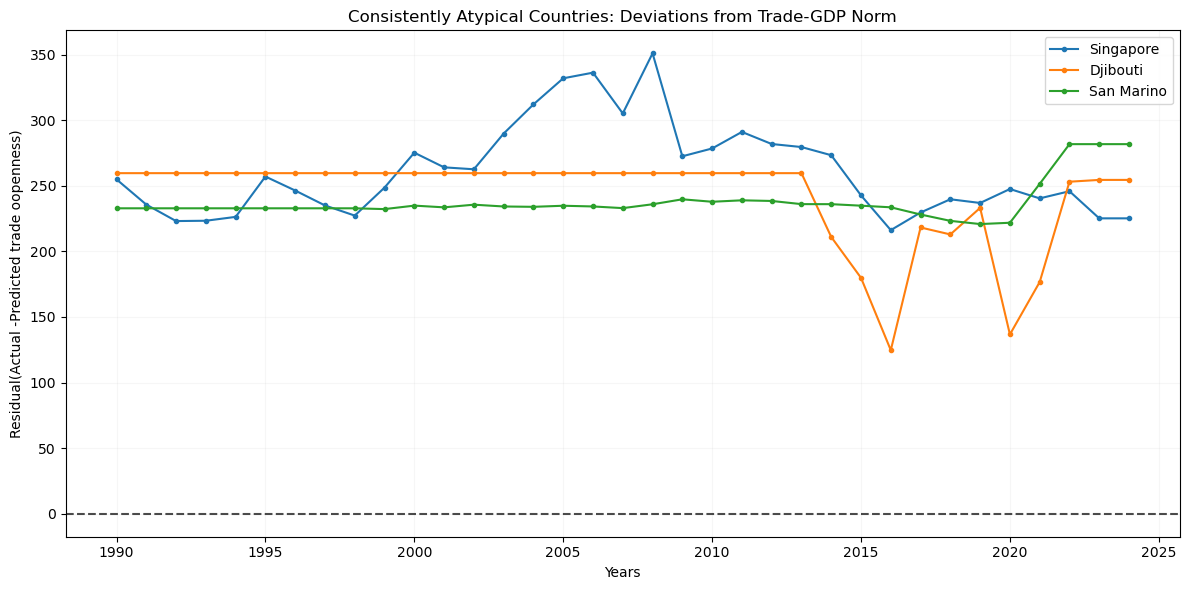

In [21]:
#visualising atypical countries
top3 = top_atypical.head(3).index.tolist()
plt.figure(figsize = (12,6))
for country in top3:
    subset = data[data.country == country]
    plt.plot(subset['year'], subset['residual'], label =country, 
             marker ='o', markersize = 3)
plt.axhline(0, color ='black', ls = '--', alpha =0.7)
plt.xlabel('Years')
plt.ylabel('Residual(Actual -Predicted trade oopenness)')
plt.title('Consistently Atypical Countries: Deviations from Trade-GDP Norm')
plt.grid(True, alpha = 0.1)
plt.legend()
plt.tight_layout()
#plt.show()
plt.savefig('atypical countries', dpi = 300, bbox_inches = 'tight', facecolor ='white')

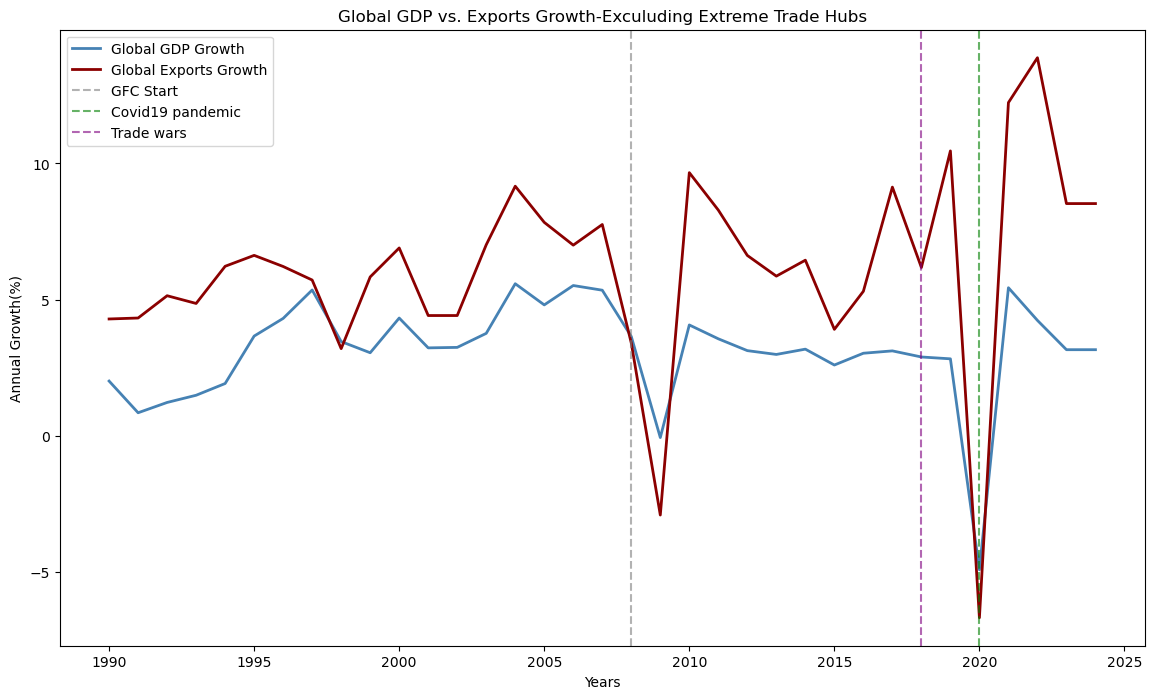

In [22]:
## identifying evidence of decoupling post 2008
extreme_hubs = top_atypical.index.tolist()
decoup_df = df[~df.country.isin(extreme_hubs)].copy()
growth_data = df[['country', 'year', 'gdp_growth', 'exports_growth']]
global_growth = growth_data.groupby('year')[['gdp_growth','exports_growth']].mean()
plt.figure(figsize = (14,8))
plt.plot(global_growth.index,global_growth.gdp_growth, label = 'Global GDP Growth', 
         color = 'steelblue', lw = 2)
plt.plot(global_growth.index,global_growth.exports_growth, label = 'Global Exports Growth', 
         color = 'darkred', lw =2)
plt.axvline(2008, color = 'gray', ls = '--', label = 'GFC Start', alpha = 0.6)
plt.axvline(2020, color = 'green', ls = '--', label = 'Covid19 pandemic',alpha = 0.6)
plt.axvline(2018, color = 'purple', ls = '--', label = 'Trade wars', alpha = 0.6)
plt.title('Global GDP vs. Exports Growth-Exculuding Extreme Trade Hubs')
plt.ylabel('Annual Growth(%)')
plt.xlabel('Years')
plt.legend()
plt.savefig('global_trade_vs_exports', dpi = 300,bbox_inches = 'tight',facecolor = 'white')


In [23]:
#stationarity testing
from statsmodels.tsa.stattools import adfuller, kpss
test_vars = [ 'exports_gdp_pct','exports_growth',
             'service_exports_gdp_pct', 'trade_openness_pct', 
        'ict_service_exports_pct', 'gdp_growth', 'inflation', 
        'service_exports_usd_log_return',
       'net_trade_usd_log_return', 
        'goods_exports_usd_log_return',
       'gdp_usd_log_return', 
    'gdp_pc_usd_log_return', 
             'log_exch_rate']
test_vars = [var for var in test_vars if var in transformed_df.columns]
results =[]
for var in test_vars:
    y = transformed_df[var].dropna()
    adf_p =adfuller(y, autolag ='AIC')
    adf_stat = adf_p[0]
    adf_pvalue = adf_p[1]
    try:
        kpss_p = kpss(y, regression ='c', nlags ='auto')
        kpss_stat = kpss_p[0]
        kpss_pvalue =kpss_p[1]
    except:
        kpss_p =np.nan
    results.append({
        'Variable': var,
        'ADF Statistic':adf_stat,
        'adf_pvalue':adf_pvalue,
        'kpss_stat': kpss_stat,
        'kpss_pvalue':kpss_pvalue})
stationarity_df =pd.DataFrame(results).set_index('Variable')
stationarity_df['stationary'] =stationarity_df.apply(
    lambda row: 'Yes' if (row['adf_pvalue']<0.05 and row['kpss_pvalue']>0.05) else 'No', axis = 1)
stationarity_df

,ADF Statistic,adf_pvalue,kpss_stat,kpss_pvalue,stationary
Variable,,,,,
exports_gdp_pct,-8.71,0.00,0.25,0.10,Yes
exports_growth,-8.81,0.00,0.30,0.10,Yes
service_exports_gdp_pct,-7.41,0.00,0.11,0.10,Yes
trade_openness_pct,-8.58,0.00,0.20,0.10,Yes
ict_service_exports_pct,-11.41,0.00,0.27,0.10,Yes
gdp_growth,-12.56,0.00,0.09,0.10,Yes
inflation,-7.43,0.00,0.87,0.01,No
service_exports_usd_log_return,-14.98,0.00,0.16,0.10,Yes
net_trade_usd_log_return,-16.66,0.00,0.16,0.10,Yes


In [24]:
#calculating trade GDP growth differential
df= transformed_df.copy().dropna()
df['trade_minus_gdp_growth'] = df['exports_growth']-df['gdp_growth']
global_gap = df.groupby('year')['trade_minus_gdp_growth'].agg(
    ['mean', 'std', 'count']).reset_index()
print('Global average trade-GDP growth differential by year')
print(global_gap.tail(10))

income_analysis = df.groupby(['year', 'income_group'])['trade_minus_gdp_growth'].mean().unstack()
print('Trade -GDP growth differential by income group (recent year)')
print(income_analysis.iloc[-1])

Global average trade-GDP growth differential by year
    year  mean   std  count
24  2015  1.39  9.56     72
25  2016  1.21  8.84     76
26  2017  2.97  9.25     84
27  2018  1.32  8.90     77
28  2019  0.54  9.13     82
29  2020  1.71 13.28     81
30  2021  3.40 13.02     84
31  2022  1.08 14.06     80
32  2023  1.17 12.23     90
33  2024  0.98 12.35     87
Trade -GDP growth differential by income group (recent year)
income_group
High income            0.04
Low income             1.35
Lower middle income   -0.58
Upper middle income    3.83
Name: 2024, dtype: float64


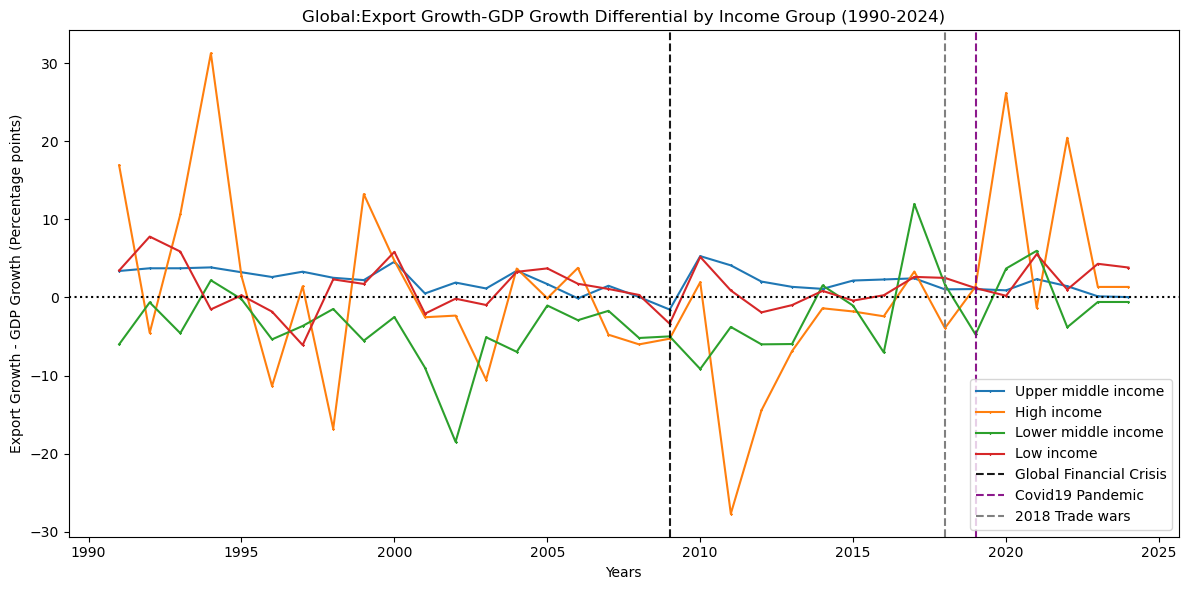

In [25]:
#visualising Trade Gdp Differential by income group
plt.figure(figsize = (12,6))
income_group = df.income_group.unique()
plt.plot(income_analysis.index, income_analysis.values, marker = '*', markersize = 1.2, label = income_group)
plt.axhline(0, color = 'black', ls = ':')
#plt.axvline(2009, color = 'green', ls ='--', label ='Post GFC')
plt.axvline(2009, color = 'black', ls ='--', label ='Global Financial Crisis', alpha = 0.9)
plt.axvline(2019, color = 'purple', ls ='--', label ='Covid19 Pandemic',alpha = 0.9)
plt.axvline(2018, color = 'gray', ls ='--', label ='2018 Trade wars',alpha = 1)
plt.title('Global:Export Growth-GDP Growth Differential by Income Group (1990-2024)')
plt.ylabel('Export Growth - GDP Growth (Percentage points)')
plt.xlabel('Years')
plt.legend()
plt.tight_layout()
plt.savefig('trade gdp diffential by income group', dpi = 300, facecolor = 'white', bbox_inches ='tight')

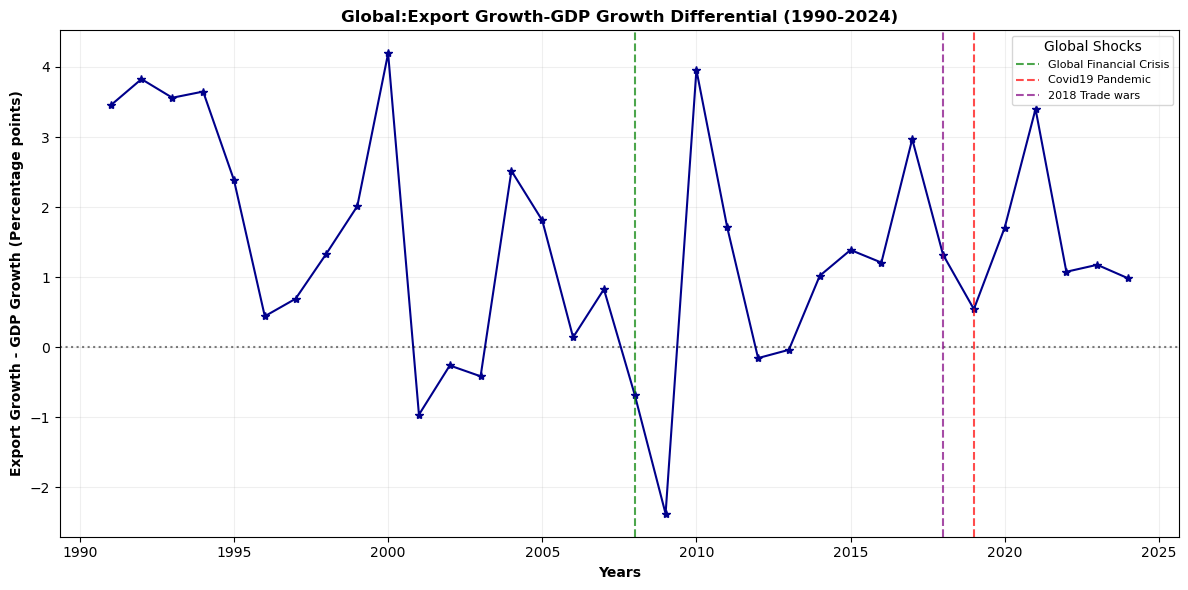

In [26]:
#visualisation global trade GDP differential
yearly_avg = df.groupby('year')['trade_minus_gdp_growth'].mean()
plt.figure(figsize = (12,6))
plt.plot(yearly_avg.index, yearly_avg.values, marker = '*', color = 'darkblue')
plt.axhline(0, color = 'black', ls = ':', alpha = 0.5)
plt.axvline(2008, color = 'green', ls ='--', label ='Global Financial Crisis', alpha = 0.7)
plt.axvline(2019, color = 'red', ls ='--', label ='Covid19 Pandemic',alpha = 0.7)
plt.axvline(2018, color = 'purple', ls ='--', label ='2018 Trade wars',alpha = 0.7)
plt.title('Global:Export Growth-GDP Growth Differential (1990-2024)', fontsize = 12, fontweight = 'bold')
plt.ylabel('Export Growth - GDP Growth (Percentage points)', fontsize = 10, fontweight = 'bold')
plt.xlabel('Years', fontsize = 10, fontweight = 'bold')
plt.legend(title = 'Global Shocks', fontsize = 8)
plt.grid(alpha = 0.2)
plt.tight_layout()
plt.savefig('trade_gdp_differencial', dpi = 300, bbox_inches ='tight', facecolor = 'white')

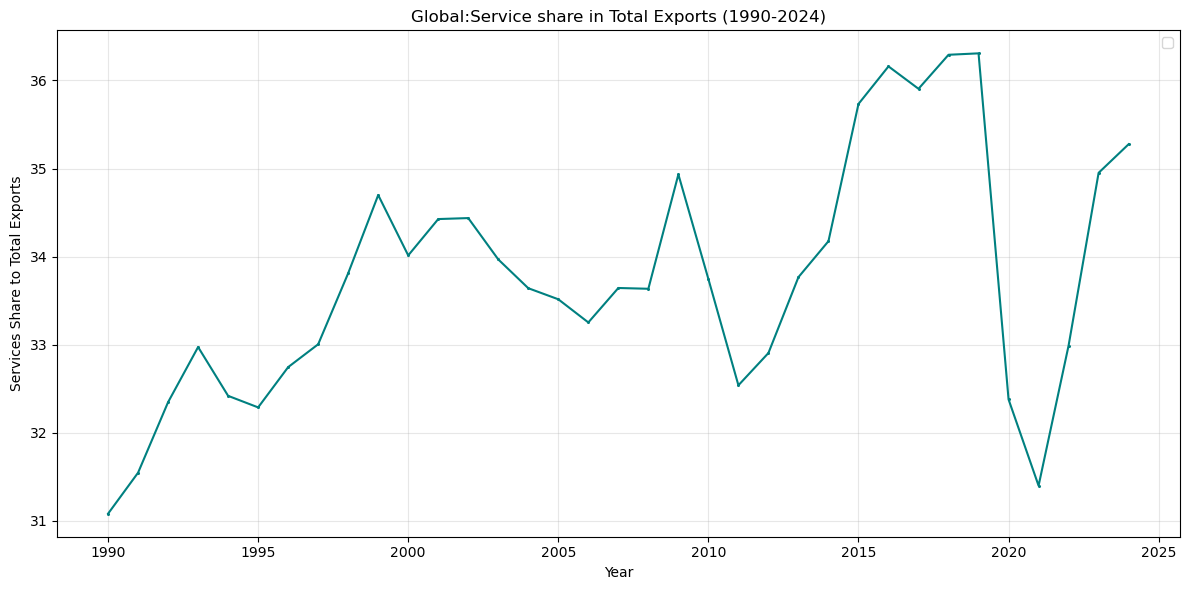

In [27]:

#Goods vs Services shift over time
#service share of services in total exports

df = vars_to_keep.copy().dropna()
#global aggregates
df['total_exports'] = df.goods_exports_usd + df.service_exports_usd
df['services_share'] = (df.service_exports_usd /df.total_exports)*100
global_shift = df.groupby('year').agg({'services_share':'mean', 'ict_service_exports_pct':'mean'}).reset_index()

#regional analysis
income_grp_shift = df.groupby(['year', 'income_group']).agg({'services_share':'mean', 'ict_service_exports_pct':'mean'}).reset_index()

#plotting global service share of service in total exports
plt.figure(figsize = (12,6))
plt.plot(global_shift.year, global_shift.services_share,marker ='o', markersize = 1.2, color ='teal')
plt.title('Global:Service share in Total Exports (1990-2024)')
plt.xlabel('Year')
plt.grid(alpha =0.3)
plt.legend()
plt.ylabel('Services Share to Total Exports')
#plt.show()
plt.tight_layout()
plt.savefig('global service share to total exports', dpi = 300, facecolor= 'white', bbox_inches = 'tight')


<Figure size 1200x600 with 0 Axes>

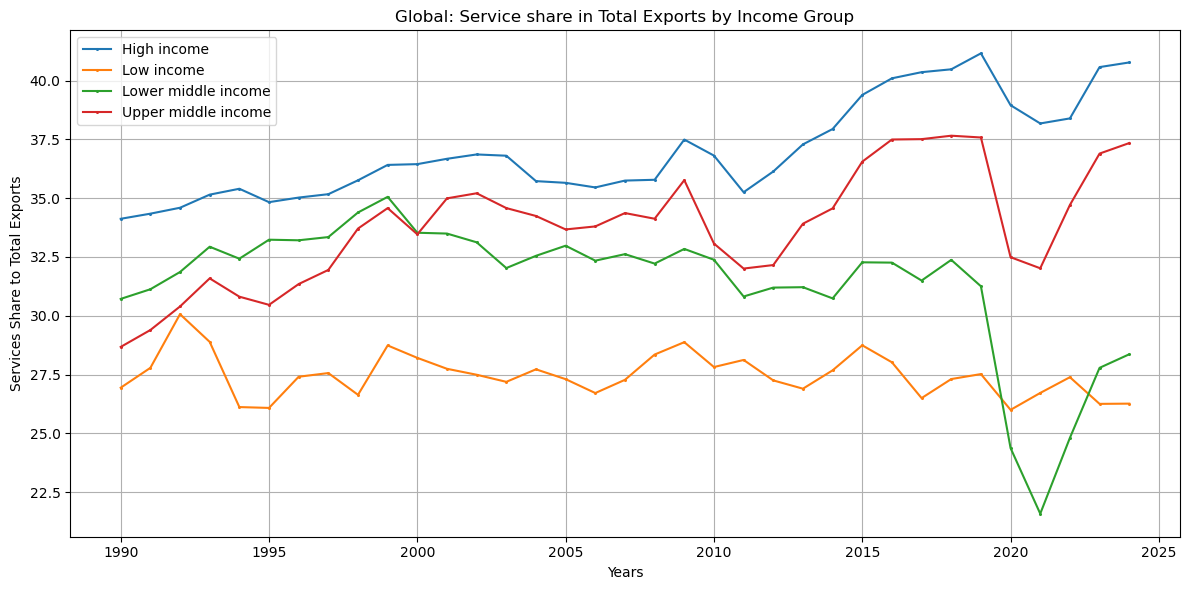

In [28]:
#plotting service share in total exports by income group
region = df.income_group.unique()
share = income_grp_shift[['year', 'income_group', 'services_share']]
plot_data = share.pivot_table(columns = 'income_group', values ='services_share', index = 'year')
plt.figure(figsize = (12,6))
plot_data.plot(marker ='o', markersize = 1.2, label = region, figsize = (12,6))
plt.title('Global: Service share in Total Exports by Income Group')
plt.xlabel('Years')
plt.grid()
plt.legend()
plt.ylabel('Services Share to Total Exports')
#plt.show()
plt.tight_layout()
plt.savefig('service share by income group', dpi = 300, bbox_inches = 'tight', facecolor ='white')

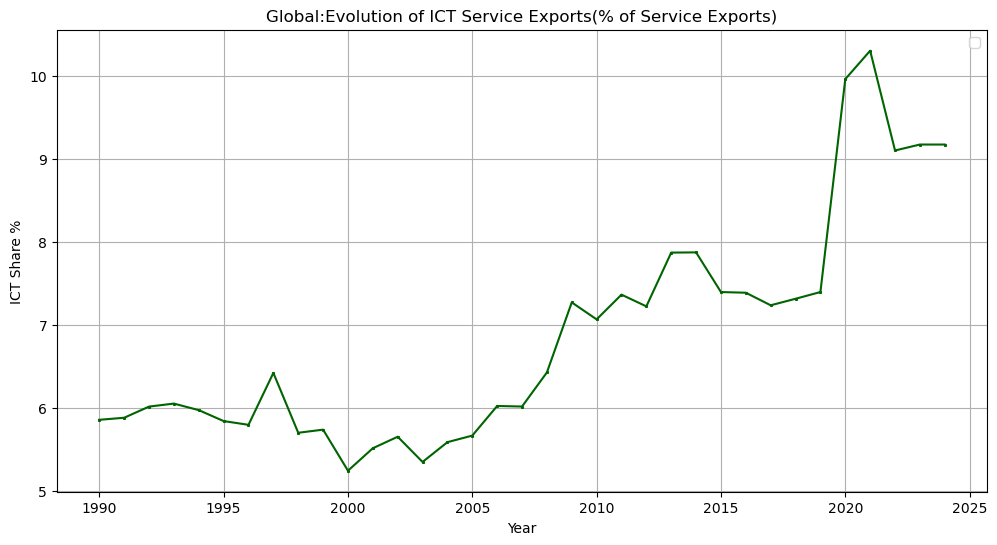

<Figure size 640x480 with 0 Axes>

In [29]:

# Calculating absolute ICT service exports in USD
df['service_exports_growth'] =df.groupby('country')['service_exports_usd'].pct_change()*100
df['ict_contribution'] = (df.ict_service_exports_pct * df.service_exports_growth)/ 100

#plotting ict service exports evolution
plt.figure(figsize = (12,6))
plt.plot(global_shift.year, global_shift.ict_service_exports_pct,marker ='s', markersize = 1.2, color ='darkgreen')
plt.title('Global:Evolution of ICT Service Exports(% of Service Exports)')
plt.xlabel('Year')
plt.grid()
plt.legend()
plt.ylabel('ICT Share %')
plt.show()
plt.tight_layout()

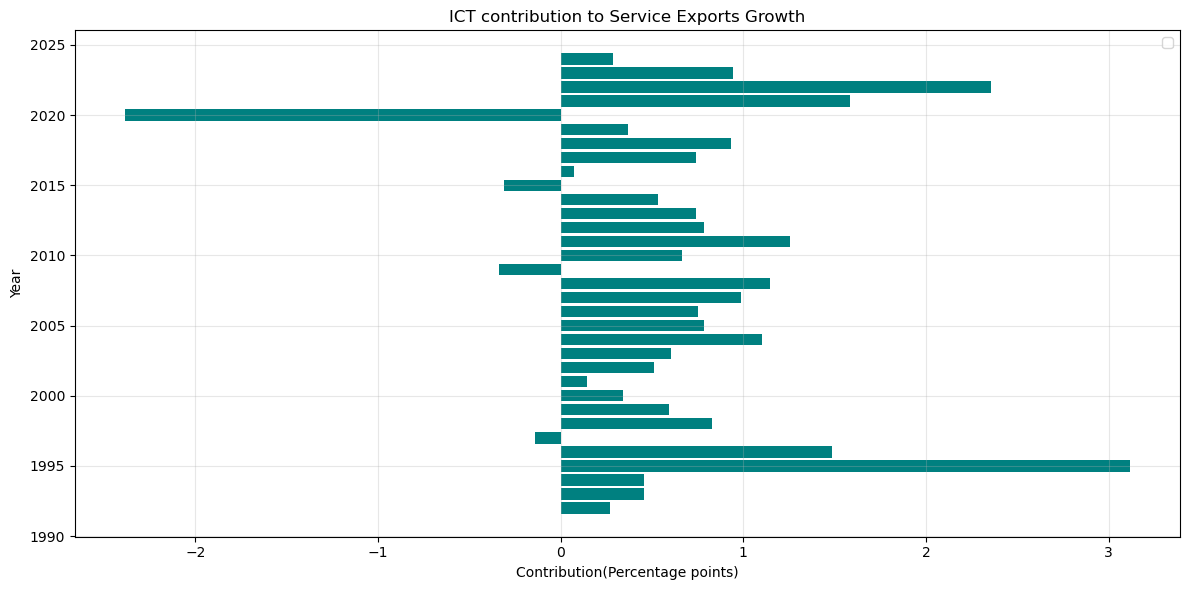

In [30]:
#avg ICT contribution by year
ict_contribution = df.groupby('year')['ict_contribution'].mean().reset_index()
ict_contribution = ict_contribution.replace([np.inf,-np.inf],np.nan).dropna()
#plotting ict contribution to exports evolution
plt.figure(figsize = (12,6))
plt.barh(ict_contribution.year, ict_contribution.ict_contribution, color ='teal')
plt.title('ICT contribution to Service Exports Growth')
plt.ylabel('Year')
plt.xlabel('Contribution(Percentage points)')
plt.grid(alpha = 0.3)
plt.legend()
#plt.ylabel('ICT Share %')
#plt.show()
plt.tight_layout()
plt.savefig('ict contribution', dpi = 300, bbox_inches = 'tight', facecolor = 'white')

<Figure size 1200x600 with 0 Axes>

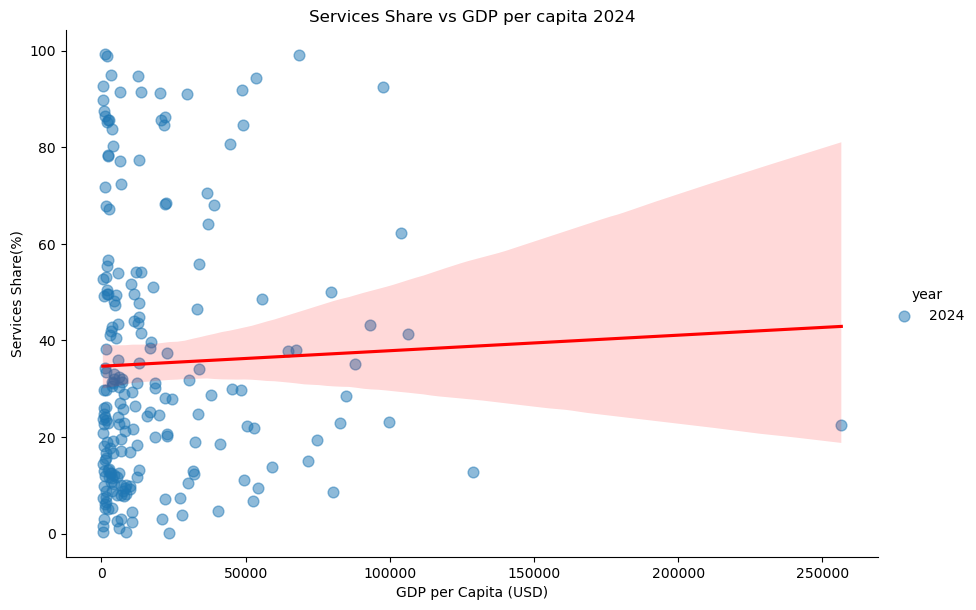

In [31]:
#how does service exports share affect GDP per capita(latest year)
latest_year = df['year'].max()
latest_data = df[df['year']== latest_year]
plt.figure(figsize =(12,6))
g = sns.lmplot(data=latest_data, x='gdp_pc_usd', y='services_share', hue = 'year',
                height=6, aspect=1.5, scatter_kws={'alpha':0.5, 's':60}, line_kws={'color':'red'}, ci =95)
plt.title(f'Services Share vs GDP per capita {latest_year}')
plt.xlabel('GDP per Capita (USD)')
plt.ylabel('Services Share(%)')
plt.show()


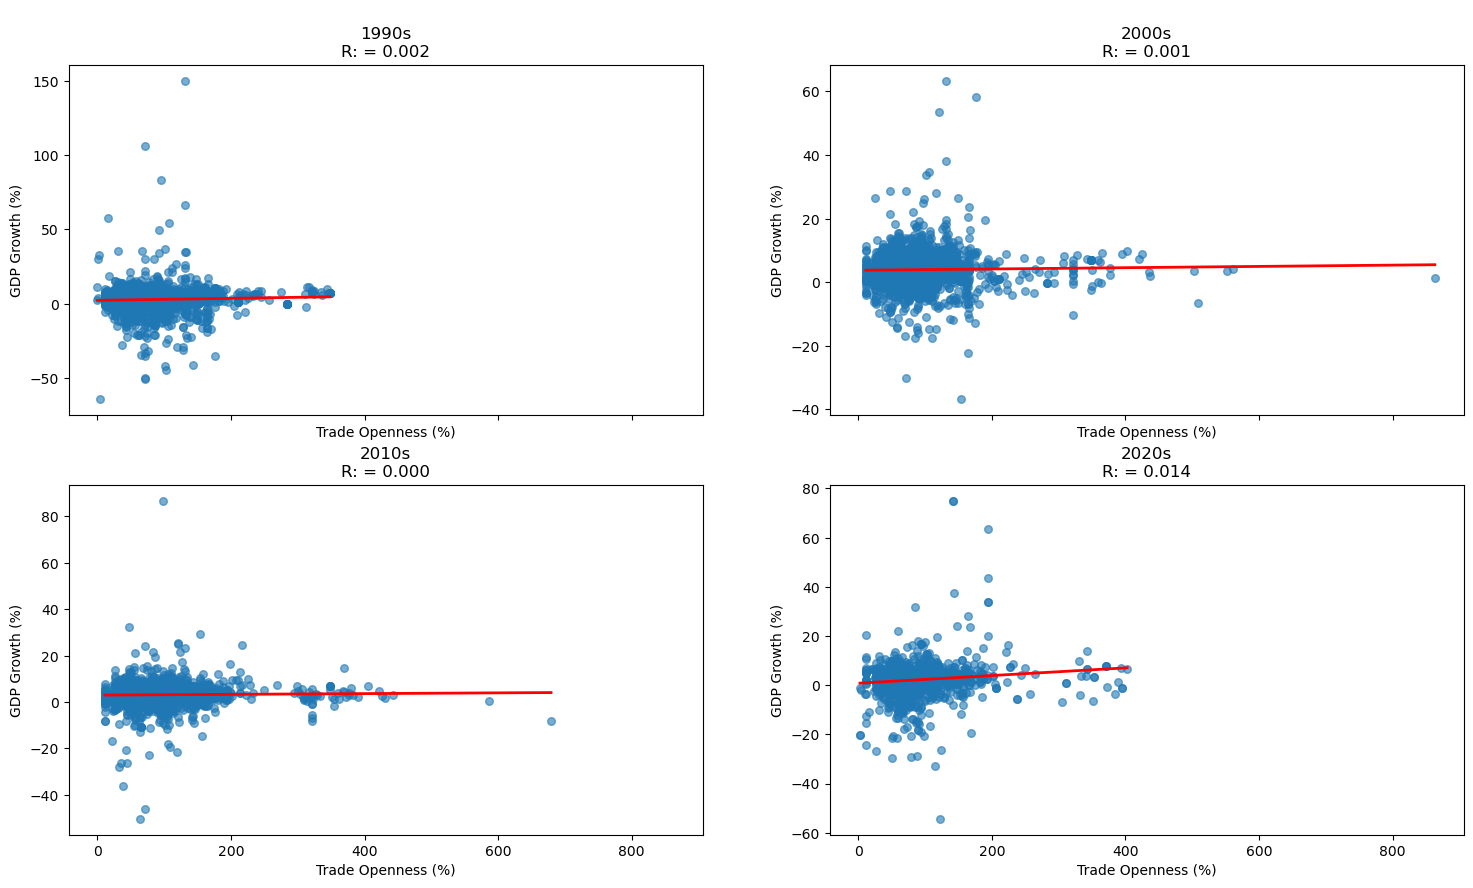

In [32]:
#static relationship analysis 

#Trade openness vs gdp growth 
df = vars_to_keep.copy()
df['decade'] =(df.year//10)*10
#scatterplots by decade

decades = sorted(df.decade.unique())
fig,axes = plt.subplots(2,2, figsize = (18,10), sharex = True)
axes = axes.flatten()
for i, decade in enumerate(decades):
    data = df[df['decade'] == decade]
    axes[i].scatter(data.trade_openness_pct, data.gdp_growth, alpha = 0.6, s = 30)
    X = sm.add_constant(data.trade_openness_pct)
    y = data.gdp_growth
    model = sm.OLS(y,X).fit()
    x_range =np.linspace(data.trade_openness_pct.min(),data.trade_openness_pct.max(),100)
    y_pred = model.params[0] + model.params[1] * x_range
    axes[i].plot(x_range, y_pred, 'r-', lw = 2)
    axes[i].set_title(f'\n{decade}s\nR: = {model.rsquared:.3f}')
    axes[i].set_xlabel('Trade Openness (%)')
    axes[i].set_ylabel('GDP Growth (%)')

        
    
  

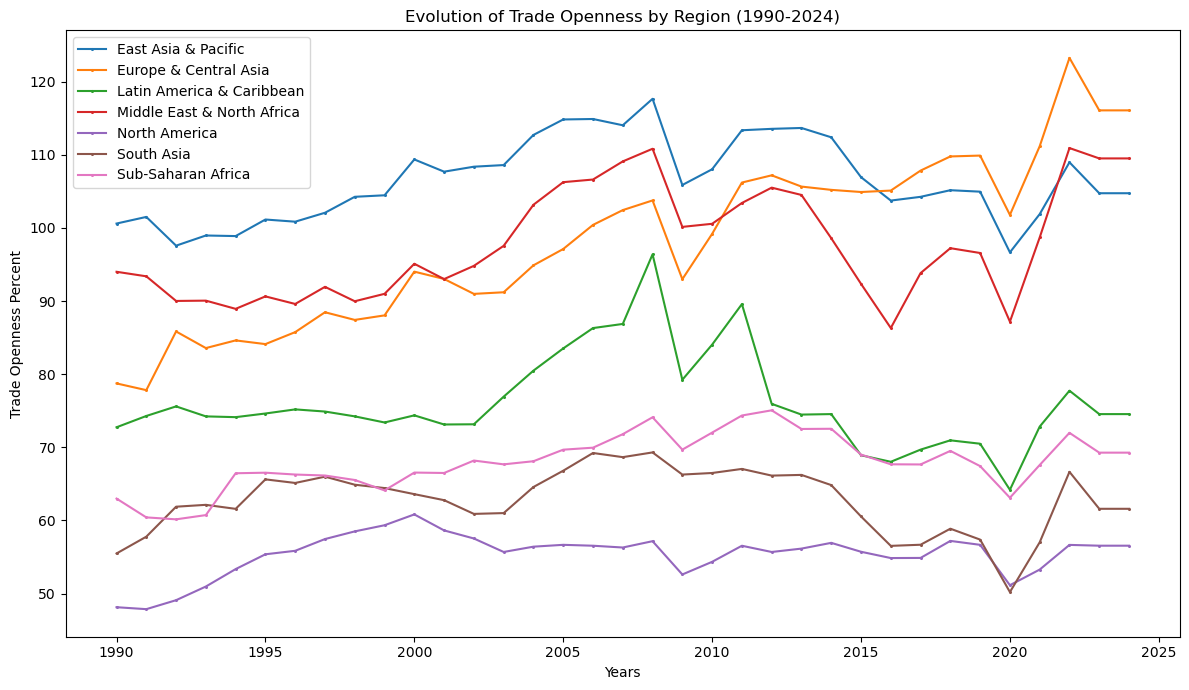

In [33]:
#visualising evolution of trade openness by region
plot_data = vars_to_keep.copy()
plot_data = plot_data.groupby(['region', 'year'])['trade_openness_pct'].mean().reset_index()
plot_data = plot_data.pivot(index= 'year',columns = 'region', values ='trade_openness_pct'
                           )
plt.figure(figsize = (12,7))
regions =list(plot_data.columns)
plt.plot(plot_data.index, plot_data.values, label = regions,marker ='o', markersize = 1.2)
plt.title('Evolution of Trade Openness by Region (1990-2024)')
plt.xlabel('Years')
plt.ylabel('Trade Openness Percent')
plt.legend()
plt.tight_layout()
plt.savefig('evolution oof trade openness', dpi = 300, bbox_inches = 'tight', facecolor ='white')

<Figure size 1000x400 with 0 Axes>

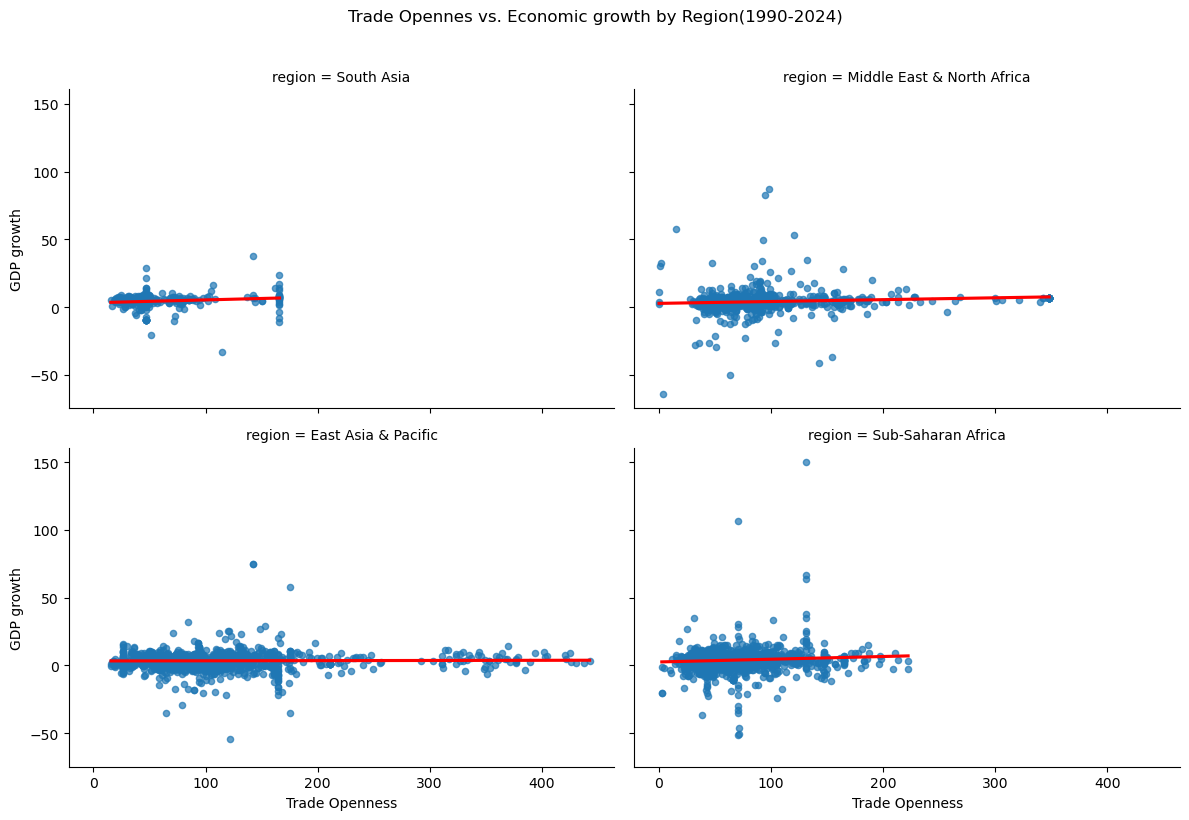

In [34]:
#region specific analysis trade openess vs economic growth

plt.figure(figsize =(10,4))
top_cs =df.groupby('region')['gdp_growth'].mean().nlargest(4).index
df_top =df[df['region'].isin(top_cs)]
g = sns.FacetGrid(df_top,col= 'region',col_wrap = 2, height =4,aspect =1.5)
g.map(sns.regplot,'trade_openness_pct', 'gdp_growth', ci =None,scatter_kws ={'alpha': 0.7,'s':20},line_kws={'color':'red'})
g.fig.suptitle('Trade Opennes vs. Economic growth by Region(1990-2024)', y =1.02)
g.set_axis_labels('Trade Openness', 'GDP growth')
g.fig.subplots_adjust(top =0.85)
plt.tight_layout()
plt.show()

In [35]:
#stability & volatility clustering
df = vars_to_keep.copy()
#global export_average
ratio_global = df.groupby('year')['exports_gdp_pct'].mean()
#rolling std(5 yr window)
roll_volatility_ratio = ratio_global.rolling(window = 5).std()
roll_volatility_ratio.dropna()
high_vol_years = roll_volatility_ratio.nlargest(5)
print('High Volatility Years')
print(high_vol_years)

peak_year = int(high_vol_years.index[0])
peak_data = df[df['year'] == peak_year][['country', 'exports_gdp_pct']]
global_mean = peak_data.exports_gdp_pct.mean()
peak_data['deviation'] =(peak_data.exports_gdp_pct-global_mean).abs()
top_outliers = peak_data.nlargest(5,'deviation')
print('top_outliers')
print(top_outliers)


High Volatility Years
year
2024   2.99
2023   2.93
2022   2.82
2011   2.13
2012   2.10
Name: exports_gdp_pct, dtype: float64
top_outliers
                   country  exports_gdp_pct  deviation
4969            Luxembourg           212.53     169.55
6964            San Marino           197.41     154.44
3499  Hong Kong SAR, China           176.76     133.78
7174             Singapore           174.30     131.32
2029              Djibouti           169.11     126.13


Text(0.5, 1.0, 'Volatility of Trade to GDP Ratio (5 Year Rolling Std)')

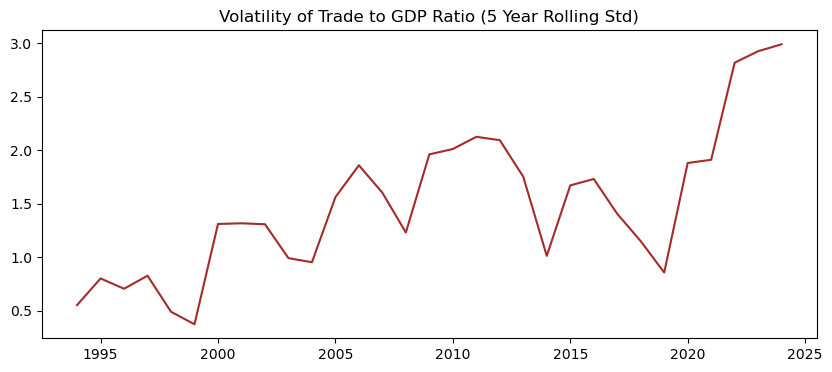

In [36]:

#visualising high/low volatility
median_vol = df.exports_gdp_pct.median()
high_vol_periods = df[df.exports_gdp_pct > median_vol *1.5]
plt.figure(figsize = (10,4))
plt.plot(roll_volatility_ratio.index, roll_volatility_ratio.values, color = 'brown')
plt.title('Volatility of Trade to GDP Ratio (5 Year Rolling Std)')

Years with the highest Trade volatility by squared returns
year
2011   0.05
2004   0.05
2021   0.05
2005   0.04
2006   0.04
Name: goods_exports_usd_log_return, dtype: float64


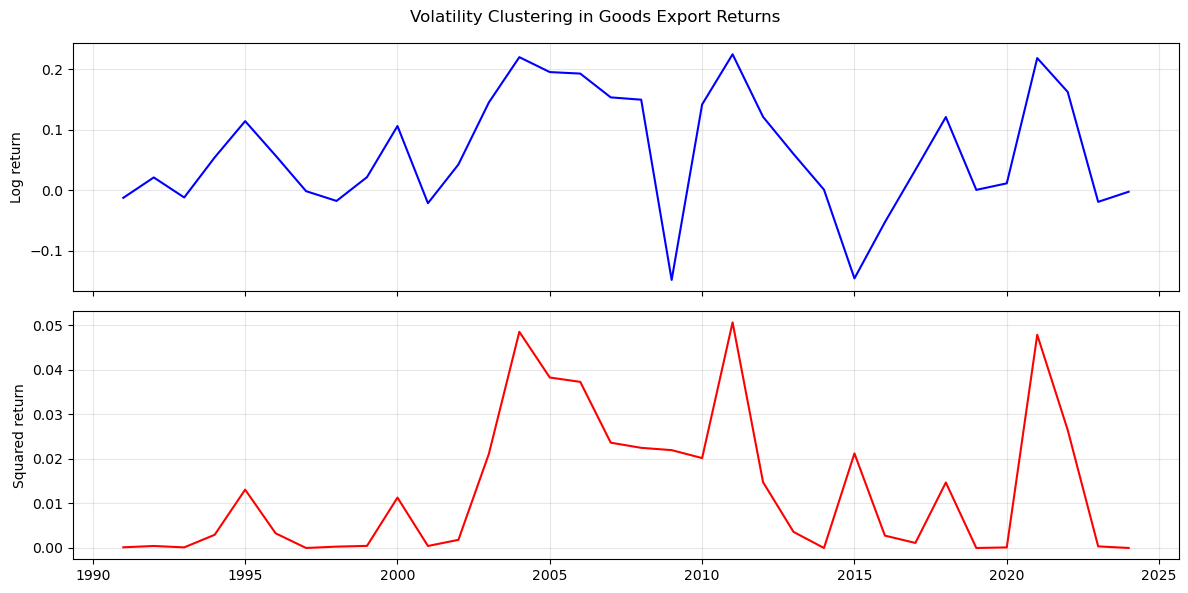

In [37]:
#checking volatility clustering 
df = transformed_df
r = df.groupby('year')['goods_exports_usd_log_return'].mean()
squared = r**2
top_vol_years = squared.nlargest(5)
print('Years with the highest Trade volatility by squared returns')
print(top_vol_years)

fig,axes = plt.subplots(2,1, figsize = (12,6), sharex = True)
axes[0].plot(r.index, r.values, color = 'blue')
axes[0].set_ylabel('Log return')
axes[0].grid(True, alpha = 0.3)

axes[1].plot(r.index, (r**2).values, color = 'red')
axes[1].set_ylabel('Squared return')
axes[1].grid(True, alpha = 0.3)
plt.suptitle('Volatility Clustering in Goods Export Returns')
plt.tight_layout()
plt.show()

In [38]:
# symmetry across expnasions/ Recessions
df = transformed_df.copy()
global_gdp = df.groupby('year')['gdp_growth'].mean()
r = df.groupby('year')['goods_exports_usd_log_return'].mean()
common_years = global_gdp.index.intersection(r.index)
recession_yrs = global_gdp[global_gdp < 0].index
vol_expansion =r[~r.index.isin(recession_yrs)].std()
vol_recession =r[r.index.isin(recession_yrs)].std()

print(f'Volatility in recession: {vol_recession:.3f}')

print(f' Volatility in expansion {vol_expansion:.3f}')      

Volatility in recession: 0.113
 Volatility in expansion 0.093


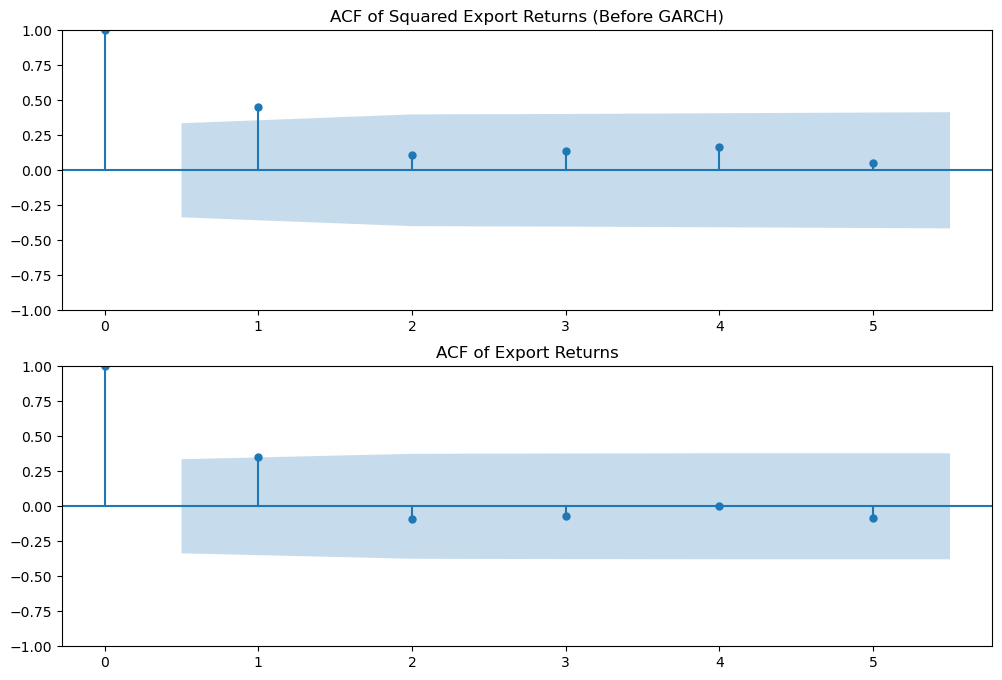

In [39]:
#univariate volatility modelling
from statsmodels.graphics.tsaplots import plot_acf
#GARCH model verification using ACF plots
r = df.groupby('year')['goods_exports_usd_log_return'].mean()
r = r.dropna()
fig, ax = plt.subplots(2,1, figsize = (12,8))
plot_acf(r**2, lags = 5, ax = ax[0], title ='ACF of Squared Export Returns (Before GARCH)')
plot_acf(r, lags = 5, ax=ax[1], title ='ACF of Export Returns')
plt.show()



In [40]:
#lm test
from statsmodels.stats.diagnostic import het_arch
lm_stat, p_value,f_stat, f_p_value =het_arch(r, maxlag =2)
print(f"Engle's ARCH-LM test p-value:{p_value:.2f}")


Engle's ARCH-LM test p-value:0.03


In [41]:
from arch import arch_model
#fitting GARCH(1,1) for goods exports
r = df.groupby('year')['goods_exports_usd_log_return'].mean()
r = r.dropna()
garch = arch_model(r, vol ='Garch', p = 1, q = 1, mean ='Constant', dist = 'Normal')
results = garch.fit(disp ='off')
print(results.summary())

                          Constant Mean - GARCH Model Results                           
Dep. Variable:     goods_exports_usd_log_return   R-squared:                       0.000
Mean Model:                       Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                GARCH   Log-Likelihood:                31.9616
Distribution:                            Normal   AIC:                          -55.9232
Method:                      Maximum Likelihood   BIC:                          -49.8177
                                                  No. Observations:                   34
Date:                          Wed, Jan 28 2026   Df Residuals:                       33
Time:                                  08:45:51   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------

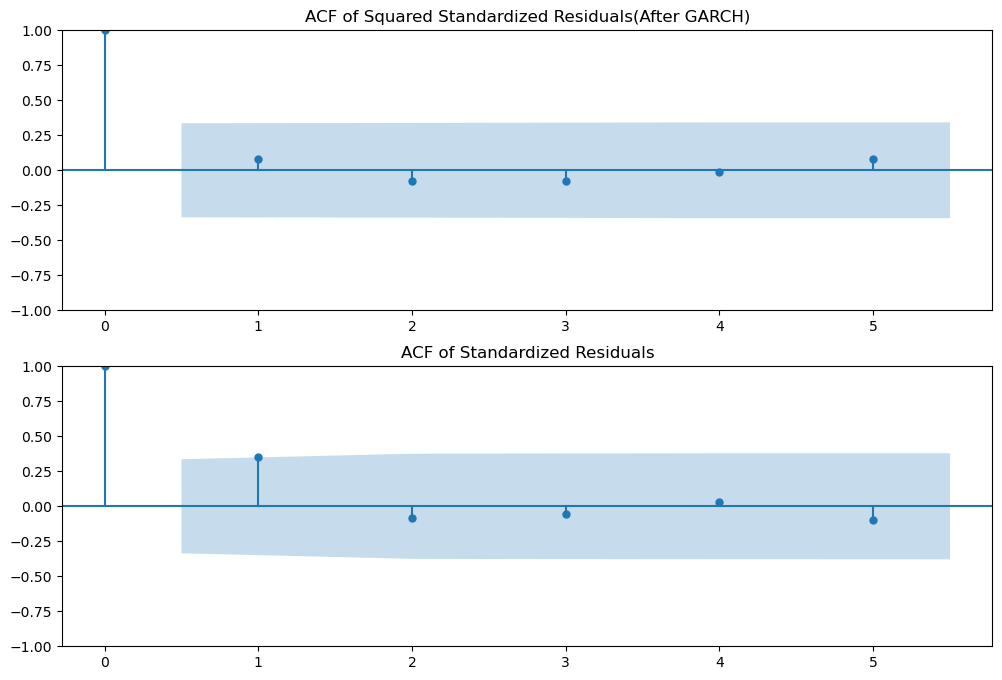

In [42]:
#acf after GARCH
cond_vol = results.conditional_volatility
std_resid = results.resid/cond_vol
fig, ax = plt.subplots(2,1, figsize = (12,8))
plot_acf(std_resid**2, lags = 5, ax = ax[0], title ='ACF of Squared Standardized Residuals(After GARCH)')
plot_acf(std_resid, lags = 5, ax=ax[1], title ='ACF of Standardized Residuals')
plt.show()


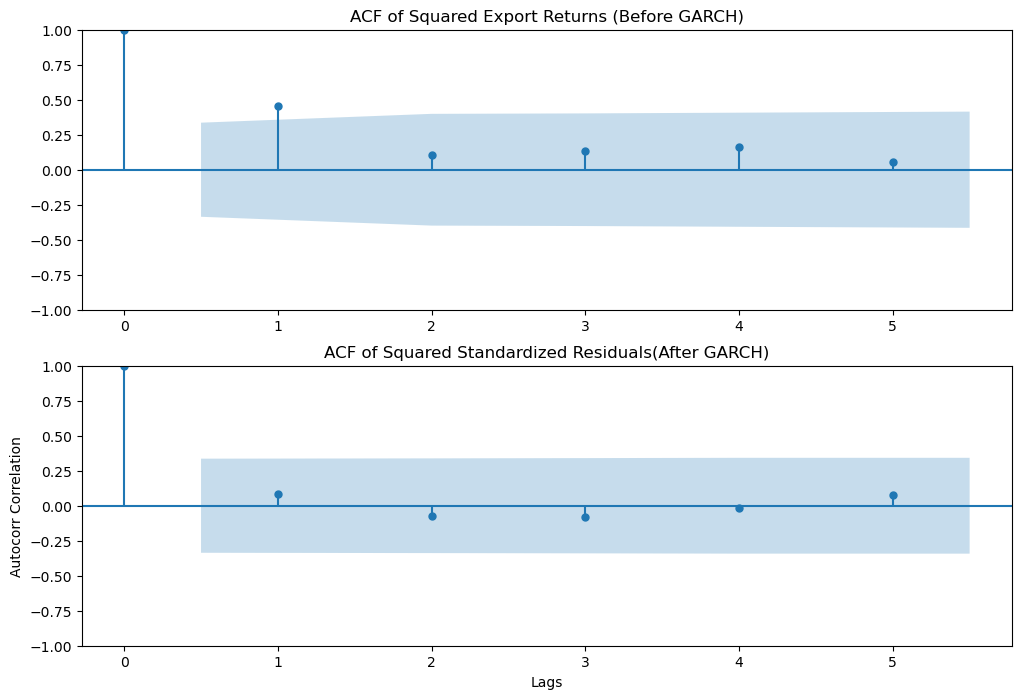

In [43]:
#ACF before vs after GARCH for squared export returns
fig, ax = plt.subplots(2,1, figsize = (12,8))
plot_acf(r**2, lags = 5, ax = ax[0], title ='ACF of Squared Export Returns (Before GARCH)')
plot_acf(std_resid**2, lags = 5, ax = ax[1], title ='ACF of Squared Standardized Residuals(After GARCH)')
plt.ylabel('Autocorr Correlation')
plt.xlabel('Lags')
#plt.show()
plt.savefig('acf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')

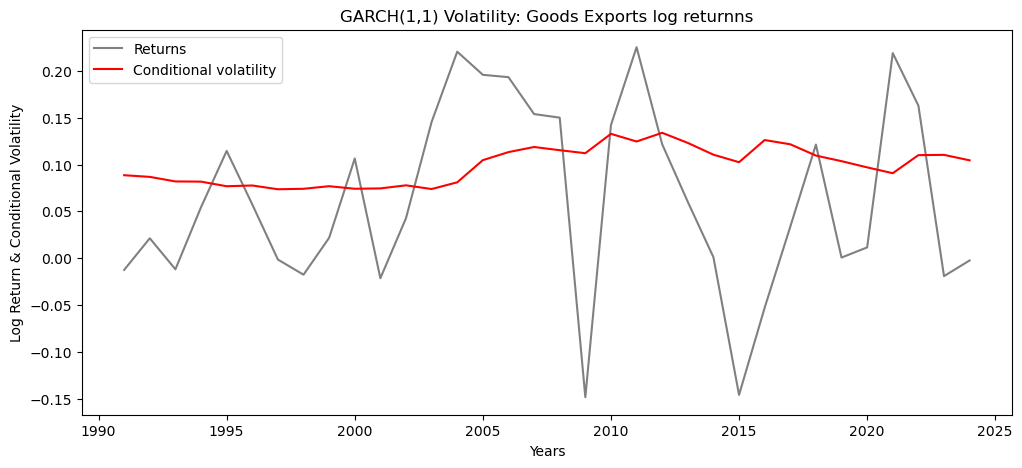

In [44]:
#visualising conditional volatility vs goods export returns
plt.figure(figsize = (12,5))
plt.plot(r.index, r.values, color= 'gray', alpha = 1, label ='Returns')
plt.plot(cond_vol.index, cond_vol.values, color= 'red', alpha = 1, label ='Conditional volatility')
plt.title('GARCH(1,1) Volatility: Goods Exports log returnns')
plt.ylabel('Log Return & Conditional Volatility')
plt.xlabel('Years')
plt.legend()
#plt.show()
plt.savefig('goods_volatility', dpi = 300, facecolor = 'white', bbox_inches = 'tight')

In [45]:
#garch for service exports usd
r2 = df.groupby('year')['service_exports_usd_log_return'].mean().dropna()
r3 = df.groupby('year')['gdp_usd_log_return'].mean().dropna()
#fit GARCH(1,1)
garch2 = arch_model(r2, vol ='Garch', p = 1, q = 1, mean ='Constant', dist = 'Normal')
results2 = garch2.fit(disp ='off')
print(results2.summary())

                           Constant Mean - GARCH Model Results                            
Dep. Variable:     service_exports_usd_log_return   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:                41.2669
Distribution:                              Normal   AIC:                          -74.5338
Method:                        Maximum Likelihood   BIC:                          -68.4284
                                                    No. Observations:                   34
Date:                            Wed, Jan 28 2026   Df Residuals:                       33
Time:                                    08:45:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-------------------------------

In [46]:
#garch for gdp usd log return
#fit GARCH(1,1)
garch3 = arch_model(r3, vol ='Garch', p = 1, q = 1, mean ='Constant', dist = 'Normal')
results3 = garch3.fit(disp ='off')
print(results3.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:     gdp_usd_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                25.8971
Distribution:                  Normal   AIC:                          -43.7941
Method:            Maximum Likelihood   BIC:                          -37.6887
                                        No. Observations:                   34
Date:                Wed, Jan 28 2026   Df Residuals:                       33
Time:                        08:45:53   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0852  1.578e-02      5.400  6.674e-08 [5.428e-0

In [47]:
#rolling volatility(5 year window)
df = transformed_df.copy()
r_export = df.groupby('year')['goods_exports_usd_log_return'].mean().dropna()
r_gdp = df.groupby('year')['gdp_usd_log_return'].mean().dropna()
common =r_export.index.intersection(r_export.index)
r_export = r_export.loc[common]
r_gdp =r_gdp.loc[common]
#rolling volatility
window = 5
vol_export = r_export.rolling(window).std()
vol_gdp = r_gdp.rolling(window).std()

#top 5 most volatile years for exports
top_vol_exports = vol_export.nlargest(3)
print('Years with the highest Trade Volatility')
for year, std in top_vol_exports.items():
    print(f'{int(year)} : {std:.2f} (~{std*100:.1f}% annual std dev)')

Years with the highest Trade Volatility
2009 : 0.15 (~14.5% annual std dev)
2011 : 0.15 (~14.5% annual std dev)
2012 : 0.14 (~14.3% annual std dev)


In [48]:

#average volatility in two eras
pre_2008 =(vol_export.index <2008) & (vol_gdp.index < 2008)
post_2008=(vol_export.index > 2008) & (vol_gdp.index > 2008)

print('Average trade volatility:')
avg_export_pre =vol_export[pre_2008].mean()
avg_export_post =vol_export[post_2008].mean()
print(f'Pre 2008:  {avg_export_pre:.3f}')
print(f'Post 2008: {avg_export_post:.3f}')
print('Average gdp volatility:')
avg_gdp_pre =vol_gdp[pre_2008].mean()
avg_gdp_post =vol_gdp[post_2008].mean()
print(f'Pre 2008:  {avg_gdp_pre:.3f}')
print(f'Post 2008: {avg_gdp_post:.3f}')
pct_change = (avg_export_post/avg_export_pre-1)*100
print(f'Trade volatility increased by {pct_change:.1f}% after the global financial crisis')

vol_ratio = vol_export/vol_gdp
top_vol_ratio = vol_ratio.nlargest(3)
print('Years when trade was most volatile relative to gdp')
print(top_vol_ratio)

Average trade volatility:
Pre 2008:  0.060
Post 2008: 0.112
Average gdp volatility:
Pre 2008:  0.098
Post 2008: 0.077
Trade volatility increased by 87.4% after the global financial crisis
Years when trade was most volatile relative to gdp
year
2010   7.14
2009   6.28
2005   1.95
dtype: float64


Volatility persistence (year to year autocorrelation):
Trade 0.63
Gdp 0.62


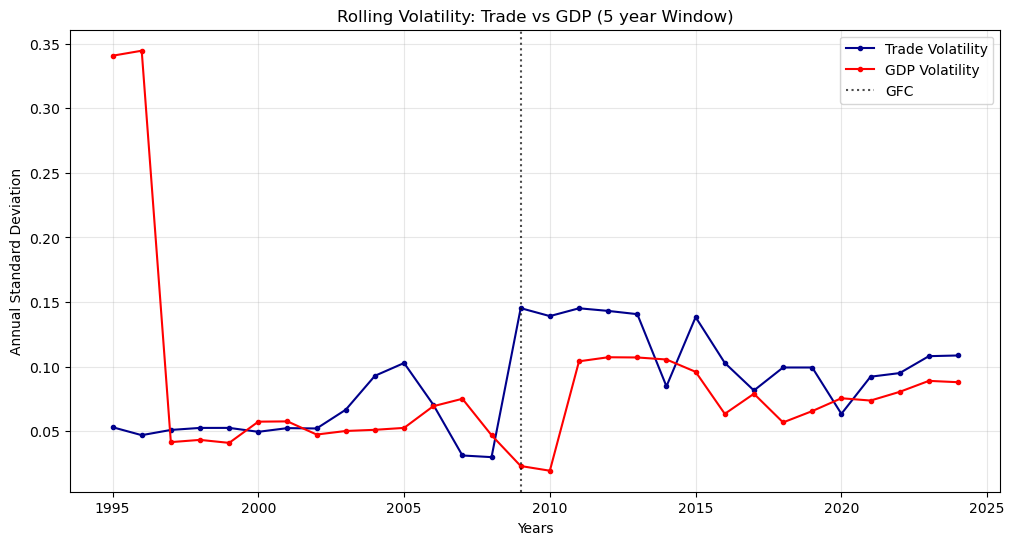

In [49]:
#volatility autocorrelation 
autocorr_export =vol_export.autocorr(lag = 1)
autocorr_gdp=vol_gdp.autocorr(lag = 1)
print('Volatility persistence (year to year autocorrelation):')
print(f'Trade {autocorr_export:.2f}')
print(f'Gdp {autocorr_gdp:.2f}')
#visualisation
vol_export = vol_export.dropna()
vol_gdp =vol_gdp.dropna()
plt.figure(figsize = (12,6))
plt.plot(vol_export.index, vol_export.values, color = 'darkblue', label = 'Trade Volatility', marker = 'o', markersize =3)
plt.plot(vol_gdp.index, vol_gdp.values, color = 'red', label = 'GDP Volatility', marker = 'o', markersize =3)
plt.axvline(2009, color = 'black', ls = ':', alpha = 0.7, label = 'GFC')
plt.title('Rolling Volatility: Trade vs GDP (5 year Window)')
plt.ylabel('Annual Standard Deviation')
plt.xlabel('Years')
plt.legend()
plt.grid(alpha = 0.3)
plt.savefig('rolling volatility', dpi =300, facecolor='white', bbox_inches = 'tight')


In [50]:
#standardized returns
std_export = r_export/vol_export
std_gdp = r_gdp/vol_gdp
std_df = pd.DataFrame({
    'export': std_export,
    'gdp':std_gdp}).dropna()
#rolling correlation of standardized returns
roll_corr = std_df.export.rolling(window).corr(std_df.gdp)
#1) when trade and gdp stopped moving together
low_corr = roll_corr[roll_corr < 0.3]
first_low = low_corr.index[0]
print(f'Trade and Gdp Decoupled after {first_low} (correlation < 3)')
pre_2008 = roll_corr[roll_corr.index < 2008].mean()
post_2008 = roll_corr[roll_corr.index > 2008].mean()
change = (post_2008 -pre_2008)
direction = 'weakned' if change < 0 else 'strengthened'
print('Average dynamic correlation:')
print(f' Pre 2008 :{pre_2008:.2f}')
print(f' Post 2008 :{post_2008:.2f}')
print(f'The Trade gdp shock linkage {direction} by {change:.2f} points after the GFC')

Trade and Gdp Decoupled after 1999 (correlation < 3)
Average dynamic correlation:
 Pre 2008 :-0.41
 Post 2008 :-0.44
The Trade gdp shock linkage weakned by -0.03 points after the GFC


In [51]:
#Crisis year: did correlation spike or collapse
crisis_yrs = [2009,2020, 2005,2015]
print('correlation in crisis years')
for year in crisis_yrs:
    if year in roll_corr.index:
        corr_val = roll_corr.loc[year]
        print(f' {year} : correlation = {corr_val:.2f} {'high synchronization' if corr_val > 0.7 else 'decoupling' if corr_val <0.2 else 'moderate link'}')

#most stabel vs most fragile periods
stable_yr = roll_corr.idxmax()
stable_val = roll_corr.max()
fragile_yr = roll_corr.idxmin()
fragile_val = roll_corr.min()
print('most stable vs most fragile years')
print(F'Peak synchronization: {stable_yr} with a strong comovement of {stable_val:.2f}')
print(F'Maximum decoupling: {fragile_yr} with a deep decoupling of {fragile_val:.2f}')

correlation in crisis years
 2009 : correlation = -0.81 decoupling
 2020 : correlation = -0.58 decoupling
 2005 : correlation = -0.01 decoupling
 2015 : correlation = -0.18 decoupling
most stable vs most fragile years
Peak synchronization: 2016 with a strong comovement of 0.70
Maximum decoupling: 2010 with a deep decoupling of -0.85


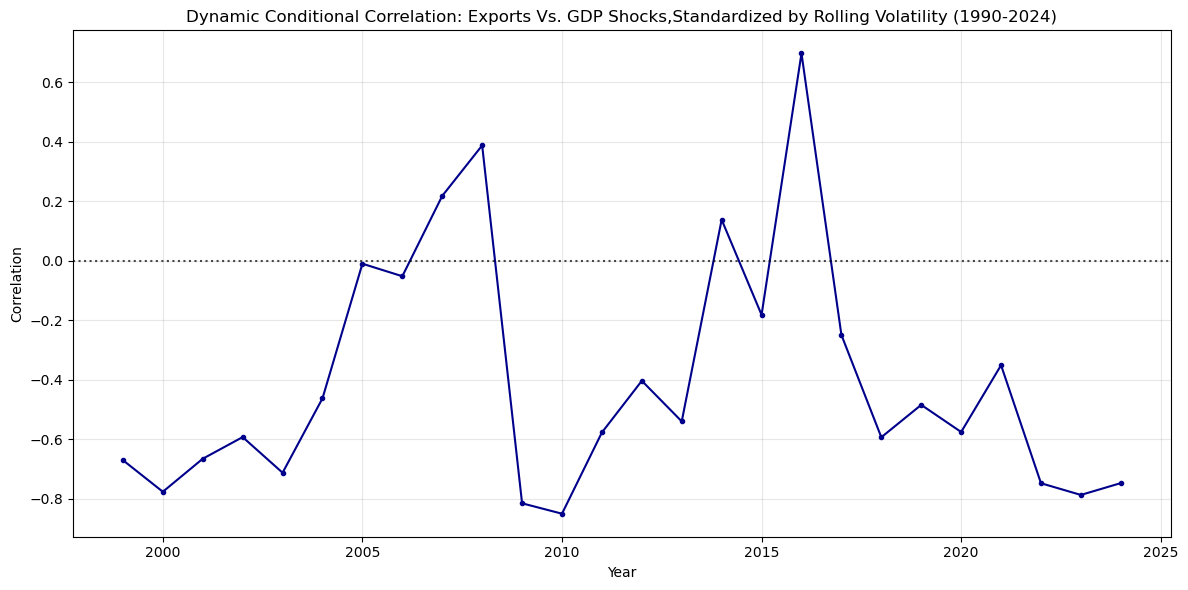

In [52]:

#visualising dcc exports vs gdp shocks
plt.figure(figsize = (12,6))
plt.plot(roll_corr.index, roll_corr.values, color = 'darkblue', marker = 'o', markersize =3)
plt.axhline(0, color = 'black', ls = ':', alpha = 0.7)
plt.title('Dynamic Conditional Correlation: Exports Vs. GDP Shocks,Standardized by Rolling Volatility (1990-2024)')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.grid(True, alpha = 0.3)
plt.tight_layout()
#plt.show()
plt.savefig('dcc', dpi =300, facecolor='white', bbox_inches = 'tight')


In [53]:

#Crisis Resilience Analysis
df = vars_to_keep.copy()
df = df.set_index('year')
crisis_yrs = list(range(2007,2011))
pre_crisis_yrs =list(range(2003,2007))
post_crisis_yrs =list(range(2011,2015))
#avg pre crisis 
pre_crisis_data = df[df.index.isin(pre_crisis_yrs)]
pre_crisis_avg = pre_crisis_data.groupby('country').agg(
    pre_trade_openness = ('trade_openness_pct','mean'),
    pre_gdp_growth = ('gdp_growth','mean'),
    pre_exports_growth =('exports_growth','mean')).reset_index()

#crisis_avg 
crisis_data = df[df.index.isin(crisis_yrs)]
crisis_avg = crisis_data.groupby('country').agg(
    _trade_openness = ('trade_openness_pct','mean'),
    crisis_gdp_growth = ('gdp_growth','mean'),
    crisis_exports_growth =('exports_growth','mean')).reset_index()
#calculating impacts
crisis_analysis = pd.merge(pre_crisis_avg, crisis_avg, on='country', how ='inner')
crisis_analysis['gdp_impact'] = crisis_analysis.crisis_gdp_growth -crisis_analysis.pre_gdp_growth
crisis_analysis['export_impact'] = crisis_analysis.crisis_exports_growth -crisis_analysis.pre_exports_growth

In [54]:
#top/worst performers - GDP impact
print('Top 5 : Countries with the Best GDP Resilience(Least Negative impact)')
top_gdp_resilience =crisis_analysis.nsmallest(5, 'gdp_impact')
print(top_gdp_resilience[['country', 'gdp_impact']].to_string(index=False))

print('Bottom 5 :Countries with the worst GDP impact(most Negative impact)')
bottom_gdp_resilience =crisis_analysis.nlargest(5, 'gdp_impact')
print(bottom_gdp_resilience[['country', 'gdp_impact']].to_string(index=False))

Top 5 : Countries with the Best GDP Resilience(Least Negative impact)
          country  gdp_impact
           Latvia      -13.57
Equatorial Guinea      -12.73
           Kuwait      -11.67
          Estonia      -10.85
          Armenia      -10.72
Bottom 5 :Countries with the worst GDP impact(most Negative impact)
    country  gdp_impact
   Zimbabwe       11.03
Timor-Leste       11.01
    Liberia       10.57
Afghanistan        6.67
    Lebanon        5.61


In [55]:
#top performers - export impact
print('Top 5 : Countries with the Best EXport Resilience(Least Negative impact)')
top_exports_resilience =crisis_analysis.nsmallest(5, 'export_impact')
print(top_exports_resilience[['country', 'export_impact']].to_string(index=False))

#countries thath grew more during the crisis
print('Countries thath grew more during the crisis')
growers =crisis_analysis[crisis_analysis.gdp_impact > 0]
print(f'{len(growers)} Countries grew more during the Crisis')
print(f'Percentage of countries : {len(growers)/len(crisis_analysis) *100:.1f}%')
print(growers[['country', 'gdp_impact', 'pre_trade_openness']].sort_values('gdp_impact', ascending = False).head(5))

Top 5 : Countries with the Best EXport Resilience(Least Negative impact)
   country  export_impact
      Chad         -90.31
Bangladesh         -32.84
    Bhutan         -29.73
Montenegro         -23.36
Mauritania         -22.45
Countries thath grew more during the crisis
51 Countries grew more during the Crisis
Percentage of countries : 23.9%
         country  gdp_impact  pre_trade_openness
212     Zimbabwe       11.03               76.34
190  Timor-Leste       11.01              100.80
110      Liberia       10.57               70.80
0    Afghanistan        6.67               46.71
108      Lebanon        5.61               82.22


In [56]:
#regional anlysis of crisis impacts
df = vars_to_keep.copy()
region_info = df[['country', 'region']]
regional_analysis = pd.merge(crisis_analysis, region_info, on = 'country', how = 'left')
region_stats = regional_analysis.groupby('region').agg(
    avg_gdp_impact =('gdp_impact','mean'),
    avg_exports_impact =('export_impact','mean'),
    avg_openness = ('pre_trade_openness', 'mean'),
    n_countries = ('country', 'count'))
region_stats = region_stats.sort_values('avg_gdp_impact')


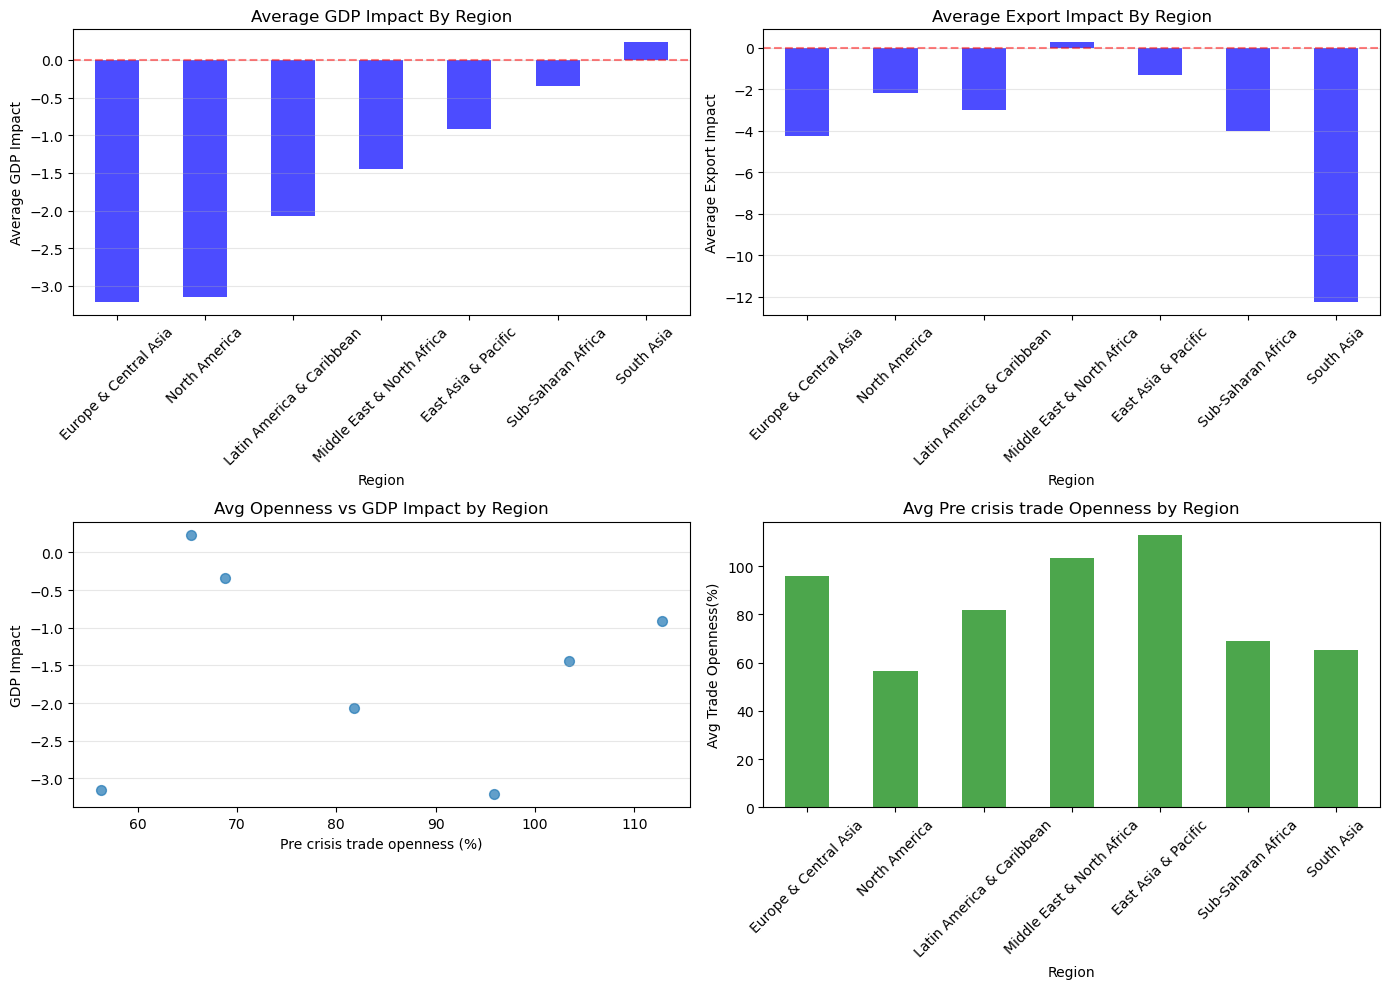

In [57]:

fig,axes = plt.subplots(2,2, figsize = (14,10))
# GDP impact by region
region_stats.avg_gdp_impact.plot(kind = 'bar', ax = axes[0,0], color = 'blue', alpha = 0.7)
axes[0,0].axhline(0,color = 'red', ls = '--',alpha = 0.5)
axes[0,0].set_title('Average GDP Impact By Region')
axes[0,0].set_xlabel('Region')
axes[0,0].set_ylabel('Average GDP Impact')
axes[0,0].tick_params(axis = 'x', rotation = 45)
axes[0,0].grid(True, alpha = 0.3, axis ='y')
#regional exports impact 

region_stats.avg_exports_impact.plot(kind = 'bar', ax = axes[0,1], color = 'blue', alpha = 0.7)
axes[0,1].axhline(0,color = 'red', ls = '--',alpha = 0.5)
axes[0,1].set_title('Average Export Impact By Region')
axes[0,1].set_xlabel('Region')
axes[0,1].set_ylabel('Average Export Impact')
axes[0,1].tick_params(axis = 'x', rotation = 45)
axes[0,1].grid(True, alpha = 0.3, axis ='y')

#scatter: openness vs GDP impact

axes[1,0].scatter(region_stats.avg_openness, region_stats.avg_gdp_impact,
                  label = region, alpha = 0.7, s = 50)
#axes[1,0].axhline(0,color = 'red', ls = '--',alpha = 0.5)
axes[1,0].set_title('Avg Openness vs GDP Impact by Region')
axes[1,0].set_xlabel('Pre crisis trade openness (%)')
axes[1,0].set_ylabel('GDP Impact')
axes[1,0].grid(True, alpha = 0.3, axis ='y')


region_stats.avg_openness.plot(kind = 'bar', ax = axes[1,1], color = 'green', alpha = 0.7)
axes[1,1].set_title('Avg Pre crisis trade Openness by Region')
axes[1,1].set_xlabel('Region')
axes[1,1].set_ylabel('Avg Trade Openness(%)')
axes[1,1].tick_params(axis = 'x', rotation =45)
axes[1,0].grid(True, alpha = 0.3, axis ='y')


plt.tight_layout()
plt.show()

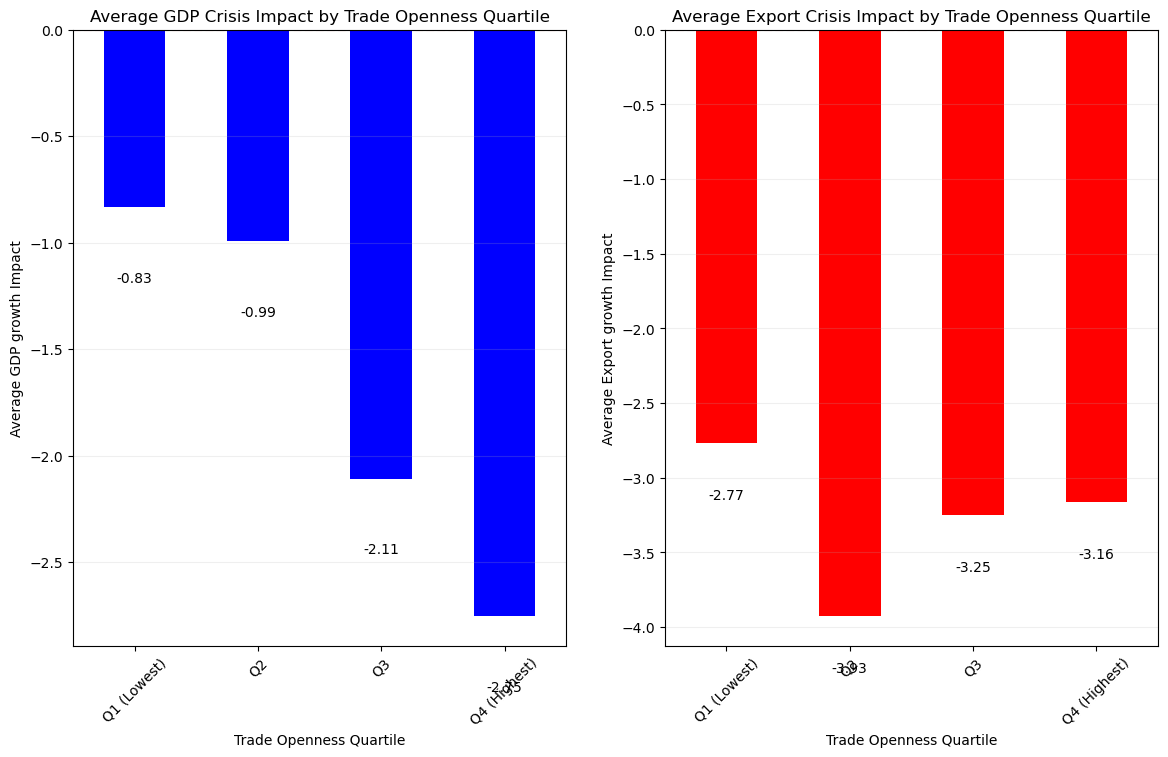

In [58]:
#quartile analysis
crisis_analysis['openness_quartile'] =pd.qcut(crisis_analysis.pre_trade_openness, q = 4,
                                              labels = ['Q1 (Lowest)', 'Q2','Q3', 'Q4 (Highest)'])
quartile_stats = crisis_analysis.groupby('openness_quartile').agg(
    avg_gdp_impact =('gdp_impact', 'mean'),
    avg_export_impact =('export_impact', 'mean'),
    n_countries =  ('country','count')).round(3)
#plotting quartiles
#gdp impcat by quartile
fig, axes = plt.subplots(1,2, figsize = (14,8))
quartile_stats.avg_gdp_impact.plot(kind ='bar', ax = axes[0], color = 'blue')
axes[0].axhline(0, color ='red', ls = '--', alpha = 0.5)
axes[0].set_title('Average GDP Crisis Impact by Trade Openness Quartile')
axes[0].set_xlabel('Trade Openness Quartile')
axes[0].set_ylabel('Average GDP growth Impact')
axes[0].tick_params(axis ='x', rotation =45)
axes[0].grid(alpha =0.2, axis = 'y')
for i,v in enumerate(quartile_stats.avg_gdp_impact):
    axes[0].text(i,v + (0.1 if v> 0 else -0.3), f'{v:.2f}',
    ha = 'center', va = 'bottom' if v >0 else 'top')
    
#exports_impact by quartile    
quartile_stats.avg_export_impact.plot(kind ='bar', ax = axes[1], color = 'red')
axes[1].axhline(0, color ='red', ls = '--', alpha = 0.5)
axes[1].set_title('Average Export Crisis Impact by Trade Openness Quartile')
axes[1].set_xlabel('Trade Openness Quartile')
axes[1].set_ylabel('Average Export growth Impact')
axes[1].tick_params(axis ='x', rotation =45)
axes[1].grid(alpha =0.2, axis = 'y')
for i,v in enumerate(quartile_stats.avg_export_impact):
    axes[1].text(i,v + (0.1 if v> 0 else -0.3), f'{v:.2f}',
    ha = 'center', va = 'bottom' if v >0 else 'top')

In [59]:
#trade openness Threshold analysis
crisis_analysis['openness_category'] = pd.cut(crisis_analysis['pre_trade_openness'],
                                             bins = [0,30,60,100,200,500], 
                                             labels = ['very low(<30%)', 'low(30-60%)', 'medium(60-100%)', 
                                             'high (100-200)', 'very high (>200%)'])
threshold_stats = crisis_analysis.groupby('openness_category').agg(avg_gdp_impact=('gdp_impact','mean'),
                                                                   avg_exports_impact=('export_impact', 'mean'),
                                                                   std_gdp_impact =('gdp_impact','std'),
                                                                   n_countries = ('country', 'count'))
print('Trade openness Threshold analysis')
threshold_stats

Trade openness Threshold analysis


,avg_gdp_impact,avg_exports_impact,std_gdp_impact,n_countries
openness_category,,,,
very low(<30%),-1.29,-4.44,2.54,11
low(30-60%),-0.67,-2.29,2.36,59
medium(60-100%),-1.80,-3.95,3.92,84
high (100-200),-2.60,-2.75,3.94,51
very high (>200%),-2.13,-5.17,1.89,8


In [60]:
#optimal openness range analysis
for threshold in [30,60,100,200]:
    below = crisis_analysis[crisis_analysis.pre_trade_openness < threshold]
    above = crisis_analysis[crisis_analysis.pre_trade_openness > threshold]
    if len(below) > 5 and len(above) > 5:
        t_stat,pvalue =stats.ttest_ind(below.gdp_impact, above.gdp_impact, equal_var = False)
        print(f' openness  < {threshold}% vs >  {threshold}%')
        print(f' Below: {len(below)} countries, avg impact:{below.gdp_impact.mean():.2f}')
        print(f' Above: {len(above)} countries, avg impact:{above.gdp_impact.mean():.2f}')
        print(f' t_stat: {t_stat:.2f}, p_value: {p_value:.3f}')
        if p_value < 0.05:
            print(f"significant difference: {'Below' if below.gdp_impact.mean() > above.gdp_impact.mean() else 'above'} performed better")
        print()

 openness  < 30% vs >  30%
 Below: 11 countries, avg impact:-1.29
 Above: 202 countries, avg impact:-1.69
 t_stat: 0.50, p_value: 0.033
significant difference: Below performed better

 openness  < 60% vs >  60%
 Below: 70 countries, avg impact:-0.77
 Above: 143 countries, avg impact:-2.11
 t_stat: 3.12, p_value: 0.033
significant difference: Below performed better

 openness  < 100% vs >  100%
 Below: 154 countries, avg impact:-1.33
 Above: 59 countries, avg impact:-2.54
 t_stat: 2.18, p_value: 0.033
significant difference: Below performed better

 openness  < 200% vs >  200%
 Below: 205 countries, avg impact:-1.65
 Above: 8 countries, avg impact:-2.13
 t_stat: 0.67, p_value: 0.033
significant difference: Below performed better



In [61]:
#recovery analysis(post crisis performance)
post_crisis_yrs =list(range(2011,2015))
post_crisis_data = df[df.year.isin(post_crisis_yrs)]
post_crisis_means = post_crisis_data.groupby('country').agg(
    post_gdp_growth=('gdp_growth', 'mean'),
    post_exports_growth =('exports_growth','mean')).reset_index()
    
recovery_analysis=pd.merge(crisis_analysis, post_crisis_means, on = 'country', how='inner')
#recovery metrics
recovery_analysis['recovery_strength']=recovery_analysis.post_gdp_growth -recovery_analysis.crisis_gdp_growth
recovery_analysis['v_shape'] = (recovery_analysis.post_gdp_growth > recovery_analysis.pre_gdp_growth).astype(int)
print(f'Recovery analysis for {len(recovery_analysis)} countries')
print('Top 10 strongest recoveries')
print(recovery_analysis.nlargest(10, 'recovery_strength')
      [['country','recovery_strength','pre_trade_openness']].to_string(index =False))
print(f'V-shaped recovery (post > pre):{recovery_analysis.v_shape.sum()} countries')
print(f'percentage with vshaped recovery: {recovery_analysis.v_shape.mean()*100:.1f}%')

Recovery analysis for 213 countries
Top 10 strongest recoveries
                 country  recovery_strength  pre_trade_openness
                   Nauru              16.84              164.29
                 Eritrea               9.25               61.49
           Faroe Islands               8.99              100.01
Northern Mariana Islands               8.55              166.26
                  Latvia               6.80               99.01
                 Estonia               6.52              131.31
                Mongolia               6.22              121.74
            Sierra Leone               5.90               29.18
                Zimbabwe               5.72               76.34
                   Palau               5.00              161.48
V-shaped recovery (post > pre):59 countries
percentage with vshaped recovery: 27.7%


In [62]:
#export composition analysis: 
#precrisis exports
pre_crisis_composition =df[df.year.isin(pre_crisis_yrs)]
pre_crisis_composition['total_exports'] = pre_crisis_composition.goods_exports_usd + pre_crisis_composition.service_exports_usd
pre_crisis_means = pre_crisis_composition.groupby('country')[['total_exports', 'service_exports_usd', 'goods_exports_usd']].mean().reset_index()
pre_crisis_means['service_share'] = (pre_crisis_means.service_exports_usd/pre_crisis_means.total_exports)*100
pre_crisis_means['goods_share'] = (pre_crisis_means.goods_exports_usd/pre_crisis_means.total_exports)*100
composition_analysis = pd.merge(crisis_analysis, pre_crisis_means[['country','service_share','goods_share']], on='country', how = 'inner')
#service heavy vs goods heavy analysis
composition_analysis['export_type'] =np.where(
    composition_analysis.service_share > 50, 'service-dominant', 'goods-dominant')
type_stats = composition_analysis.groupby('export_type').agg(
    avg_gdp_impact =('gdp_impact','mean'),
    avg_exports_impact =('export_impact','mean'),
    n_countries =('country','count')
)
print('export_composition')
print(f'{composition_analysis.export_type.value_counts()}')
print('export composition analysis ')
print(type_stats)

export_composition
export_type
goods-dominant      163
service-dominant     50
Name: count, dtype: int64
export composition analysis 
                  avg_gdp_impact  avg_exports_impact  n_countries
export_type                                                      
goods-dominant             -1.81               -3.94          163
service-dominant           -1.20               -1.11           50


In [63]:
#trade policy impacts 
#preparing data for random effects model
from linearmodels.panel import RandomEffects

fx_df = transformed_df.copy()
fx_df =fx_df.sort_values(['country', 'year'])
fx_df['total_exports'] = fx_df.goods_exports_usd + fx_df.service_exports_usd
fx_df['log_total_exports'] =np.log(fx_df['total_exports'])
fx_df['total_exports_log_return']=fx_df.groupby('country')['log_total_exports'].diff()
fx_df['fx_change']=fx_df.groupby('country')['exch_rate'].pct_change()*100
fx_df['real_exch_rate'] =fx_df.fx_change - fx_df.inflation
fx_df['fx_volatility'] =fx_df.groupby('country')['fx_change'].rolling(window - 3, min_periods =2).std().reset_index(
    level =0, drop = True)
fx_df['fx_change_lag1'] =fx_df.groupby('country')['fx_change'].shift(1)
fx_df['total_exports_lag1'] =fx_df.groupby('country')['total_exports'].shift(1)
fx_df=fx_df.set_index(['country','year'])
fx_df =fx_df.sort_index()
key_vars = ['total_exports','exch_rate','fx_change','gdp_usd']
fx_clean = fx_df.dropna(subset =key_vars)

In [64]:
#random effects model formula(model 1_total exports)
formula = """
log_total_exports~1+log_gdp_usd+  
log_exch_rate+log_gdp_pc_usd+inflation+trade_openness_pct"""

model = RandomEffects.from_formula(formula = formula, data = fx_clean)
results = model.fit()
print(results.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:      log_total_exports   R-squared:                        0.8921
Estimator:              RandomEffects   R-squared (Between):              0.8543
No. Observations:                2466   R-squared (Within):               0.6699
Date:                Wed, Jan 28 2026   R-squared (Overall):              0.8126
Time:                        08:45:56   Log-likelihood                   -864.06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4066.5
Entities:                         124   P-value                           0.0000
Avg Obs:                       19.887   Distribution:                  F(5,2460)
Min Obs:                       1.0000                                           
Max Obs:                       34.000   F-statistic (robust):             1154.1
                            

In [65]:
#extracting important values
print('coeffs')
print(results.params)
print('pvalues')
print(results.pvalues)
print('rsquared')
print(results.rsquared)

coeffs
Intercept             7.06
log_gdp_usd           0.66
log_exch_rate         0.01
log_gdp_pc_usd        0.01
inflation            -0.01
trade_openness_pct    0.01
Name: parameter, dtype: float64
pvalues
Intercept            0.00
log_gdp_usd          0.00
log_exch_rate        0.08
log_gdp_pc_usd       0.00
inflation            0.00
trade_openness_pct   0.00
Name: pvalue, dtype: float64
rsquared
0.8920696963303391


In [66]:
#robustnesschecks
#fixed effects vs random effects

from linearmodels import PanelOLS
from linearmodels.panel import compare

##fixed effects model for comparison
fe_model =PanelOLS.from_formula(formula, data =fx_clean).fit()
print(compare({'FE': fe_model, 'RE':results}))

                       Model Comparison                      
                                       FE                  RE
-------------------------------------------------------------
Dep. Variable           log_total_exports   log_total_exports
Estimator                        PanelOLS       RandomEffects
No. Observations                     2466                2466
Cov. Est.                      Unadjusted          Unadjusted
R-squared                          0.8585              0.8921
R-Squared (Within)                 0.6059              0.6699
R-Squared (Between)                0.9114              0.8543
R-Squared (Overall)                0.8585              0.8126
F-statistic                        2985.4              4066.5
P-value (F-stat)                   0.0000              0.0000
===================== =================== ===================
Intercept                          3.2530              7.0556
                                 (16.747)            (28.383)
log_gdp_

In [67]:

#goods model
formula2 = """
log_goods_exports_usd~1+log_gdp_usd+
fx_volatility+trade_openness_pct+inflation+EntityEffects
"""
model2 = RandomEffects.from_formula(formula = formula2, data = fx_clean)
results2 = model2.fit()
print(results2.summary)


                          RandomEffects Estimation Summary                         
Dep. Variable:     log_goods_exports_usd   R-squared:                        0.7641
Estimator:                 RandomEffects   R-squared (Between):              0.7041
No. Observations:                   2342   R-squared (Within):               0.5651
Date:                   Wed, Jan 28 2026   R-squared (Overall):              0.6599
Time:                           08:45:56   Log-likelihood                   -1034.9
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      1892.4
Entities:                            119   P-value                           0.0000
Avg Obs:                          19.681   Distribution:                  F(4,2337)
Min Obs:                          1.0000                                           
Max Obs:                          33.000   F-statistic (robust):            

In [68]:
#services model
formula3 = """
log_service_exports_usd~1+log_gdp_usd+
fx_volatility+trade_openness_pct+inflation+EntityEffects
"""

model3 = RandomEffects.from_formula(formula = formula3, data = fx_clean)
results3 = model3.fit()
print(results3.summary)

                           RandomEffects Estimation Summary                          
Dep. Variable:     log_service_exports_usd   R-squared:                        0.7222
Estimator:                   RandomEffects   R-squared (Between):              0.6903
No. Observations:                     2342   R-squared (Within):               0.5239
Date:                     Wed, Jan 28 2026   R-squared (Overall):              0.6444
Time:                             08:45:56   Log-likelihood                   -1400.4
Cov. Estimator:                 Unadjusted                                           
                                             F-statistic:                      1518.8
Entities:                              119   P-value                           0.0000
Avg Obs:                            19.681   Distribution:                  F(4,2337)
Min Obs:                            1.0000                                           
Max Obs:                            33.000   F-statist